## MSDS 7331 Lab Two: Classification

### Authors: Jaren Shead, Kristin Henderson, Tom Hines

#### Setup & Data Import

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import time

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor, Lasso, LassoCV
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn import metrics as mt
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# Display plots inline
%matplotlib inline

# Load dataset
df = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Preparation

#### Data Cleaning & Preprocessing

In [2]:
# Make a copy of the dataset
df_clean = df.copy()

# Replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)

# Fill missing values
df_clean[['medical_specialty', 'payer_code', 'race']] = df_clean[['medical_specialty', 'payer_code', 'race']].fillna('Unknown')
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown/None')
df_clean[['max_glu_serum', 'A1Cresult']] = df_clean[['max_glu_serum', 'A1Cresult']].fillna('Untested')

# Convert numeric categorical columns to strings explicitly (not category yet)
numeric_categorical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[numeric_categorical_cols] = df_clean[numeric_categorical_cols].astype(str)

# Drop unnecessary columns
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

# Define ordinal category orders
category_orders = {
    'readmitted': ['<30', '>30', 'NO'],
    'max_glu_serum': ['Untested', 'Norm', '>200', '>300'],
    'A1Cresult': ['Untested', 'Norm', '>7', '>8'],
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
            '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
}

# Convert ordinal variables
for col, order in category_orders.items():
    df_clean[col] = pd.Categorical(df_clean[col], categories=order, ordered=True)

# Convert drug variables to ordinal categories
drug_order = ['No', 'Down', 'Steady', 'Up']
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']
for col in drug_cols:
    df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  object  
 4   discharge_disposition_id  101766 non-null  object  
 5   admission_source_id       101766 non-null  object  
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

In [3]:
print(df_clean['change'].describe())
print(df_clean['change'].value_counts())

count     101766
unique         2
top           No
freq       54755
Name: change, dtype: object
change
No    54755
Ch    47011
Name: count, dtype: int64


## Classification Task

Our first task is predicting if a patient will have a change in medication, the variable `change`. From an insurance company's perspective, this may be an important thing to predict to distribute resources and identify inaccuracies to cut costs. 

#### EDA & Visualizations of the Response Variable `change`

This is a quick look at the distribution of each numerical variable for patients with a change and those without.

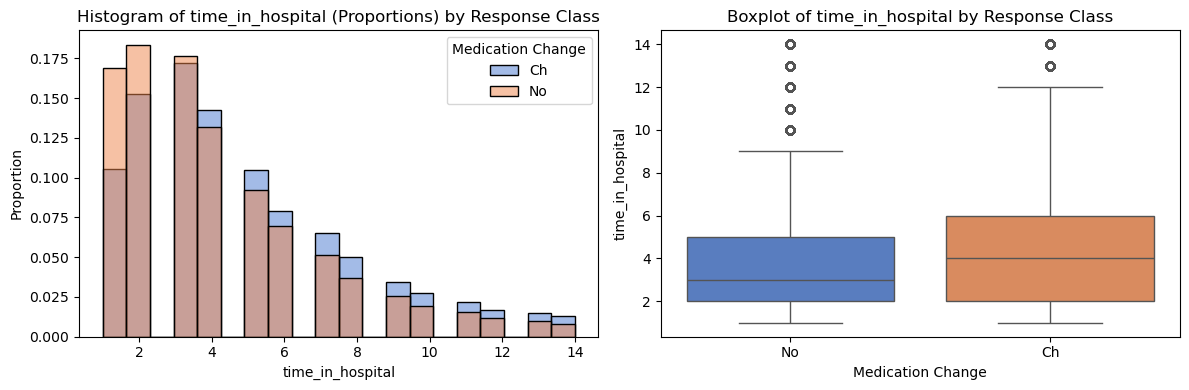

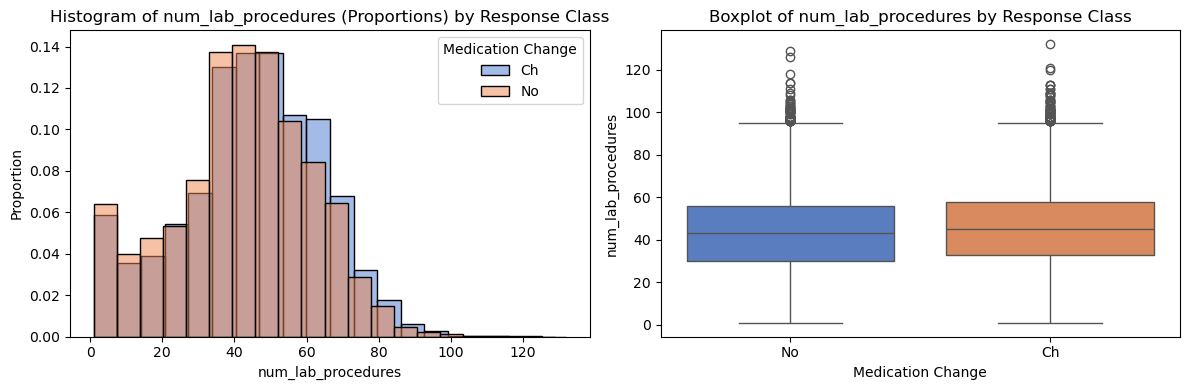

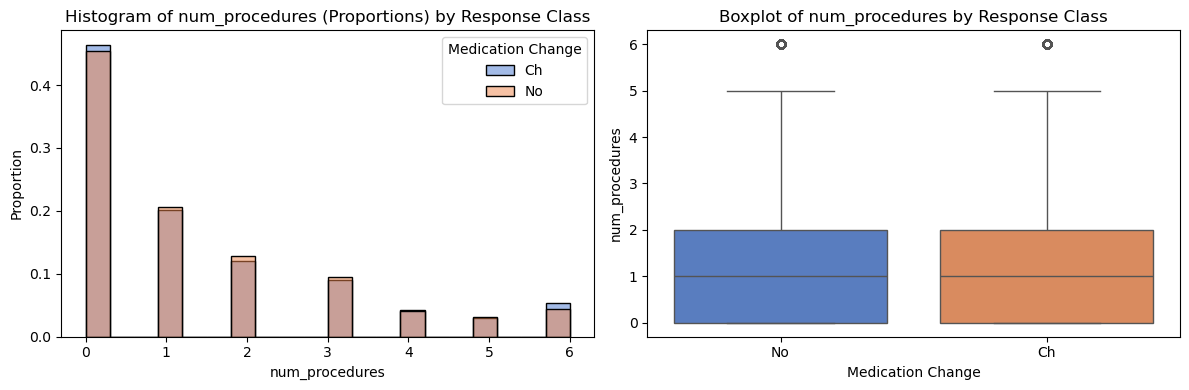

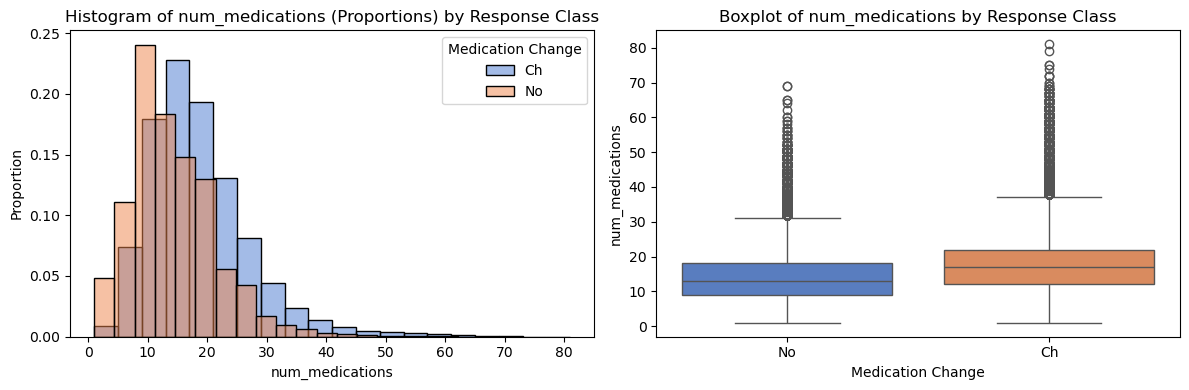

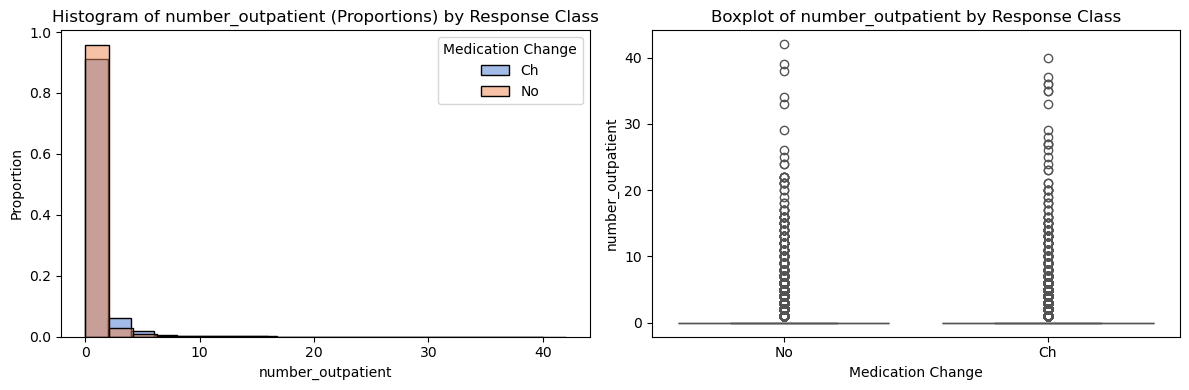

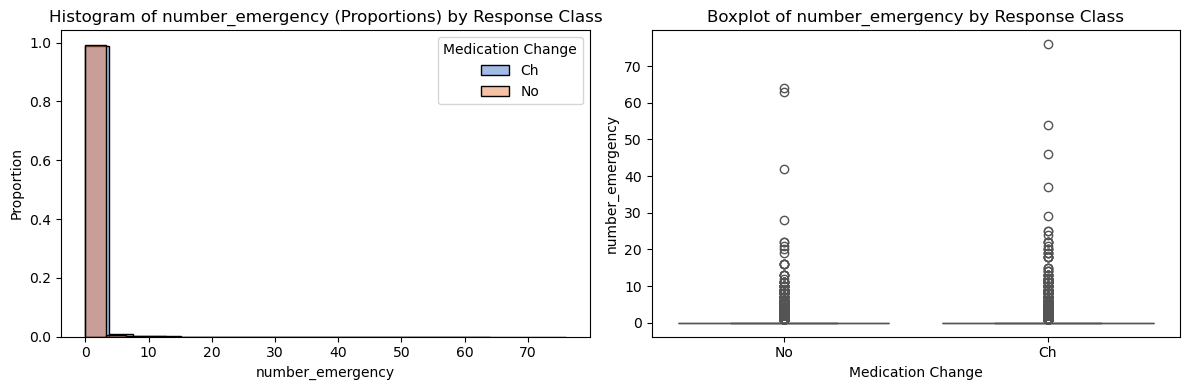

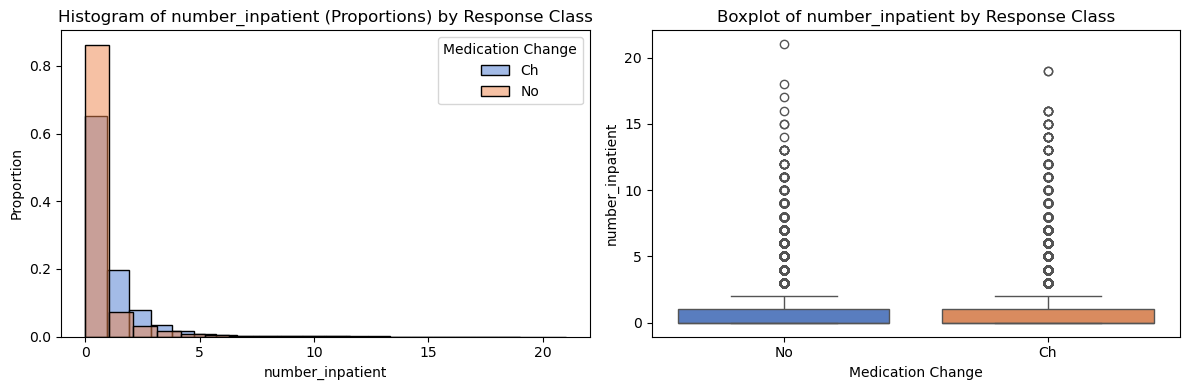

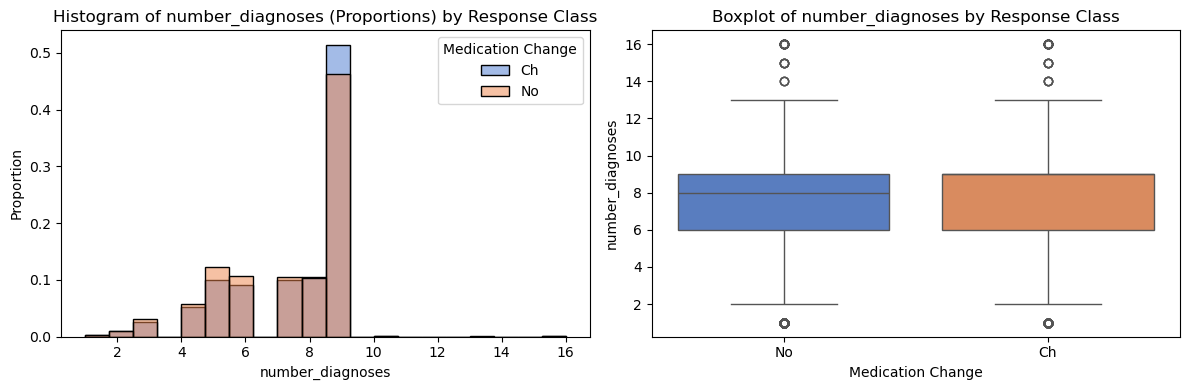

In [4]:
change_order = ['Ch', 'No']

# List of numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Set the color palette
palette = sns.color_palette("muted", n_colors=len(change_order))

# Generate plots for each numeric column
for col in numeric_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Histogram with proportions
    for idx, category in enumerate(change_order):
        subset = df_clean[df_clean['change'] == category]
        sns.histplot(subset[col], bins=20, color=palette[idx], label=category, alpha=0.5, stat="probability", ax=axes[0])

    axes[0].set_title(f"Histogram of {col} (Proportions) by Response Class")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Medication Change')

    # Boxplot
    sns.boxplot(data=df_clean, x='change', y=col, hue='change', palette=palette[:len(change_order)], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col} by Response Class")
    axes[1].set_xlabel('Medication Change')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    # plt.savefig(f'plots/plot_{col}_by_readmitted.png', bbox_inches="tight") 
    plt.show()

This create cross-tabulations for each categorical variable by response class, showing the percentage of patients in each category.

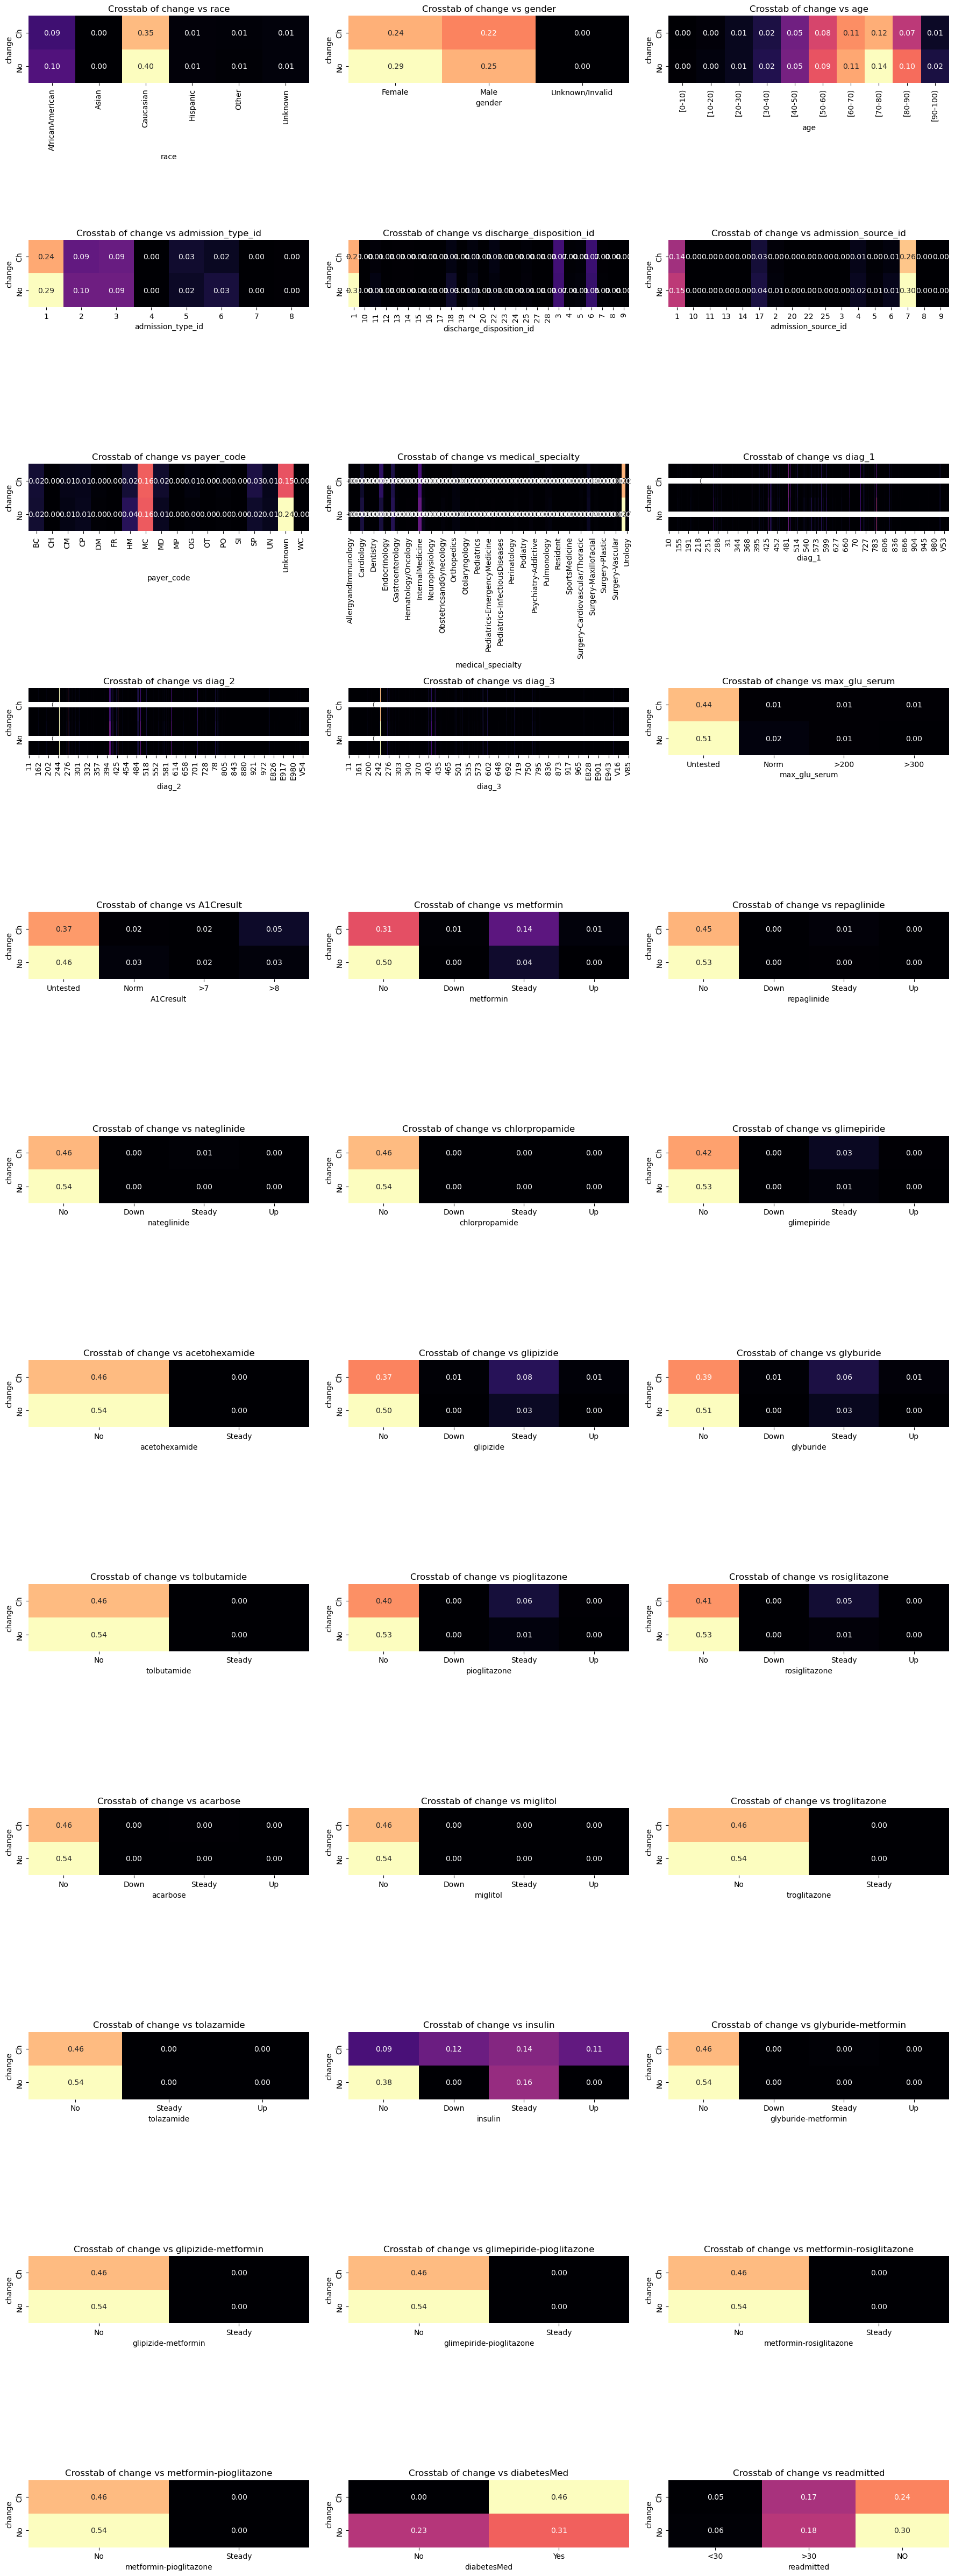

In [5]:
subset_df = df_clean.select_dtypes(include=['object', 'category'])
# subset_df = subset_df.drop(['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'patient_nbr', 'admission_type_id', 'max_glu_serum', 'A1Cresult'], axis=1)

# subset_df.columns

response = 'change'  # Attribute of interest
other_columns = [col for col in subset_df.columns if col != response]  # Exclude target

crosstab_results = {}
for column in other_columns:
    crosstab_results[column] = pd.crosstab(subset_df[response], subset_df[column])

def create_heatmaps(crosstab_results, response, normalization='none', n_cols=4, cmap="plasma"):
    """
    Creates a grid of heatmaps for given crosstab results.

    Parameters:
        crosstab_results (dict): Dictionary of crosstabs for each feature.
        response (str): Name of the response variable.
        normalization (str): Normalization type ('row', 'column', 'overall').
        n_cols (int): Number of columns in the subplot grid.
        cmap (str): Colormap for the heatmaps.
    """
    n_features = len(crosstab_results)  # Total features to plot
    n_rows = -(-n_features // n_cols)  # Compute rows by rounding up

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=False, sharey=False)
    axes = np.ravel(axes)  # Flatten axes for consistent 1D handling

    # Loop through crosstabs and create heatmaps
    for i, (col, crosstab) in enumerate(crosstab_results.items()):
        
        # Normalize the crosstab based on the selected normalization
        if normalization == 'none':
            normalized_crosstab = crosstab 
        elif normalization == 'row':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)    # Normalize by row
        elif normalization == 'column':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=0), axis=1)    # Normalize by column
        elif normalization == 'overall':
            normalized_crosstab = crosstab / crosstab.values.sum()              # Normalize overall
        else:
            raise ValueError("Invalid normalization type. Choose 'none', row', 'column', or 'overall'.")

        # Plot heatmap
        sns.heatmap(normalized_crosstab, annot=True, fmt=".2f" if normalization != 'none' else "d", cmap=cmap, cbar=False, ax=axes[i])
        
        axes[i].set_title(f"Crosstab of {response} vs {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(response)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    # plt.savefig(f'plots/crossTab_heatmaps.png')
    plt.show()

# create_heatmaps(crosstab_results, response='readmitted', normalization='none', n_cols=4, cmap="plasma")       #   Crosstab Heatmap: No Normalization, Raw Counts
# create_heatmaps(crosstab_results, response='readmitted', normalization='row', n_cols=4, cmap="plasma")        #   Crosstab Heatmap: No Normalization, Proportion of Factor Levels within the Response Variable
# create_heatmaps(crosstab_results, response='readmitted', normalization='column', n_cols=4, cmap="plasma")     #   Crosstab Heatmap: Column Normalization, Proportion of Factor Levels within the Predictor Variable
create_heatmaps(crosstab_results, response='change', normalization='overall', n_cols=3, cmap="magma")      #   Crosstab Heatmap: Overall Normalization, Proportion of Total Data


- Histograms and boxplots of numerical variables showed differences in distribution for `time_in_hospital` and `num_medications` across response classes.
- Categorical variables such as `insulin`, `diabetesMed`, `readmitted status`, and various medication/testing variables displayed different distributions between groups, suggesting they could be useful predictors.


#### Separating the Explanatory and Response Variables

In [6]:
# Extract response variable
y_change = df_clean['change']
X_change = df_clean.drop(columns=['change'])

# Convert target variable to a binary numeric (1 for 'Ch', 0 for 'No')
y_binary = y_change.copy()
y_binary = np.where(y_change == 'Ch', 1, 0)

#### Encoding & Scaling

In [7]:
# Define categorical and numerical feature subsets
categorical_cols = X_change.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_change.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables
X_change_encoded = pd.get_dummies(X_change, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues

# Define the preprocessing pipeline
# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')


- The response variable `change` was separated from the explanatory features.
- Categorical variables were encoded, and scaling was applied to numerical variables for appropriate models.
  

#### Strategy for Performance Validation

- The dataset was split into training and holdout sets (80/20 split) while stratifying the response variable to maintain class balance.
- A stratified $k$-fold cross-validation (CV) approach was used:
  - Feature selection and hyperparameter tuning were performed using 2-5 fold CV, depending on computational constraints.
  - To speed up hyperparameter tuning, a 50% subsample of the training data was used.
  - Final model comparison was conducted using 10-fold CV to obtain stable estimates of performance and generalization. 
- The holdout test set (20%) was reserved for final model evaluation after tuning.
- Given the dataset size (~100,000 records), an 80/20 split was chosen to:
  1. Ensure sufficient samples for training and validation, while leaving enough data for an unbiased test set.
  2. Preserve representation across categories, ensuring the training set captures the variance in categorical features.


#### Creating a Stratified Holdout Test Set

In [8]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_change_encoded, y_binary, test_size=0.2, random_state=1234)

#### Feature Engineering & Selection

In [9]:
# ----- LASSO Feature Selection -----
start_time = time.time()

lasso_selector = LassoCV(cv=5, random_state=1234)

# Create a pipeline with preprocessing and LASSO
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', lasso_selector)
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Retrieve feature names after transformation
feature_names = numerical_cols.tolist() + [col for col in X_train.columns if col not in numerical_cols]

# Select features with non-zero coefficients
lasso_selected_features = [feature_names[i] for i in range(len(feature_names)) if lasso_selector.coef_[i] != 0]

print(f"LASSO time: {(time.time() - start_time)/60:.2f} minutes")

# ----- Random Forest Feature Selection -----
start_time = time.time()

rf_selector = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_selector.fit(X_train, y_train)

# Get feature importances and select top features
feature_importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns)
rf_selected_features = feature_importances[feature_importances > np.percentile(feature_importances, 75)].index.tolist()  # Top 25% features

print(f"RF time: {(time.time() - start_time)/60:.2f} minutes")

# - `lasso_selected_features` is the list of features selected by LASSO
# - `rf_selected_features` is the list of features selected by Random Forest
# - `X_change` is the original dataset before encoding
# - `categorical_cols` and `numerical_cols` are already defined

# Convert feature lists to DataFrames for processing
lasso_df = pd.DataFrame({'Feature': lasso_selected_features})
rf_df = pd.DataFrame({'Feature': rf_selected_features})

# ----- Extract Original Variable Names for LASSO -----
lasso_numeric = lasso_df['Feature'][lasso_df['Feature'].isin(numerical_cols)]
lasso_categorical = lasso_df['Feature'][~lasso_df['Feature'].isin(numerical_cols)]
lasso_original_categorical = lasso_categorical.str.replace(r'_[^_]+$', '', regex=True)  # Remove one-hot encoding suffixes

# Combine numeric and cleaned categorical features
lasso_unique_features = pd.concat([lasso_numeric, lasso_original_categorical]).unique()

# ----- Extract Original Variable Names for Random Forest -----
rf_numeric = rf_df['Feature'][rf_df['Feature'].isin(numerical_cols)]
rf_categorical = rf_df['Feature'][~rf_df['Feature'].isin(numerical_cols)]
rf_original_categorical = rf_categorical.str.replace(r'_[^_]+$', '', regex=True)

# Combine numeric and cleaned categorical features
rf_unique_features = pd.concat([rf_numeric, rf_original_categorical]).unique()

# ----- Find Common & Unused Features -----
dataset_features = pd.Series(X_change.columns)  # Original dataset BEFORE encoding

# Features selected by both LASSO & RF
common_features = pd.Series(list(set(lasso_unique_features) & set(rf_unique_features)))

# Features in dataset but not selected by either method
unused_features = dataset_features[~dataset_features.isin(pd.concat([pd.Series(lasso_unique_features), pd.Series(rf_unique_features)]))]

# Print Results
print("\nLASSO Unique Selected Features (Original Variables):")
print(lasso_unique_features)

print("\nRandom Forest Unique Selected Features (Original Variables):")
print(rf_unique_features)

print("\nCommon Features Selected by Both LASSO and RF:")
print(common_features.to_list())

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO or RF):")
print(unused_features.to_list())


LASSO time: 0.36 minutes
RF time: 3.88 minutes

LASSO Unique Selected Features (Original Variables):
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'race' 'gender' 'age'
 'admission_type_id' 'discharge_disposition_id' 'admission_source_id'
 'payer_code' 'medical_specialty' 'diag_1' 'diag_2' 'diag_3'
 'max_glu_serum' 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide'
 'chlorpropamide' 'glimepiride' 'glipizide' 'glyburide' 'pioglitazone'
 'rosiglitazone' 'acarbose' 'insulin' 'glyburide-metformin' 'diabetesMed'
 'readmitted']

Random Forest Unique Selected Features (Original Variables):
['time_in_hospital' 'num_lab_procedures' 'num_procedures'
 'num_medications' 'number_outpatient' 'number_emergency'
 'number_inpatient' 'number_diagnoses' 'race' 'gender' 'age'
 'admission_type_id' 'discharge_disposition_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'metformin' 'r

#### Creating a Reduced Dataset with Important Variables (`X_train_selected` and `X_test_selected`)

In [10]:
# Train/test split was already created. Do this to avoid leakage.

# Identify encoded features corresponding to original features selected by both LASSO and RF
selected_encoded_features = [col for col in X_train.columns if any(feature in col for feature in common_features)]

# Create a Reduced Dataset with Encoded Features
X_train_selected = X_train[selected_encoded_features].copy()
X_test_selected = X_test[selected_encoded_features].copy()  # Ensure same columns in test set

# Ensure train and test have the same columns (Test set may lack some categories)
X_test_selected = X_test_selected.reindex(columns=X_train_selected.columns, fill_value=0)

# Final check
print("Final Training Shape:", X_train_selected.shape)
print("Final Testing Shape:", X_test_selected.shape)

Final Training Shape: (81412, 2351)
Final Testing Shape: (20354, 2351)


#### Creating a Second Dataset Filtering to Fewer Variables (`X_train_super_reduced` and `X_test_super_reduced`)

In [11]:
# Reducing the dataset further just to see...
# Because accuracy is so high, maybe we don't need all of these features and based on EDA we can drop several.

# Super Reduced Dataset
# Only key medication & two numerical features
# super_reduced_features = ['glyburide-metformin', 'glyburide', 'acarbose', 'rosiglitazone', 'pioglitazone', 'repaglinide',
#                           'metformin', 'nateglinide', 'diabetesMed', 'glimepiride', 'glipizide', 'chlorpropamide', 
#                           'insulin', 'num_medications', 'time_in_hospital']

# Only key medication features
# super_reduced_features = ['glyburide-metformin', 'glyburide', 'acarbose', 'rosiglitazone', 'pioglitazone', 'repaglinide',
#                           'metformin', 'nateglinide', 'glimepiride', 'glipizide', 'chlorpropamide', 
#                           'insulin']

# Medication variables with the largest variation between levels (top level < 90%)
# super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin']
# These 4 give these results:
# Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9295, AUC: 0.9571, F1: 0.9175

# Medication variables with most frequent levels < 95%)
# super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin', 'glimepiride', 'rosiglitazone', 'pioglitazone']
# These 7 give these results:
# Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9891, AUC: 0.9941, F1: 0.9881

super_reduced_features = ['glyburide', 'metformin', 'glipizide', 'insulin', 'glimepiride', 'rosiglitazone', 'pioglitazone', 'repaglinide']
super_reduced_encoded_features = [col for col in X_train.columns if any(feature in col for feature in super_reduced_features)]

# Create the super reduced dataset
X_train_super_reduced = X_train[super_reduced_encoded_features].copy()
X_test_super_reduced = X_test[super_reduced_encoded_features].copy()
X_test_super_reduced = X_test_super_reduced.reindex(columns=X_train_super_reduced.columns, fill_value=0)

print("Super Reduced Training Shape:", X_train_super_reduced.shape)
print("Super Reduced Testing Shape:", X_test_super_reduced.shape)

# In case we want to add numerical variables
# Only keep numerical columns that exist in the super reduced dataset
numerical_cols_reduced = [col for col in numerical_cols if col in X_train_super_reduced.columns]

# Update the preprocessor with the new numerical columns
preprocessor_reduced = ColumnTransformer([('num', StandardScaler(), numerical_cols_reduced)], remainder='passthrough')


Super Reduced Training Shape: (81412, 39)
Super Reduced Testing Shape: (20354, 39)



- An initial feature selection process reduced the dataset to the most important variables.
- A further-reduced dataset was created, retaining only 8 highly relevant medication-related features.
- Modeling and evaluation were performed with both sets.


## Modeling & Evaluation: Classification Task

#### Define Classifiers

We tested four classifiers:  
1. **SGD Logistic Regression**  
   - Selected for interpretability and computational efficiency when applied to large datasets.
2. **SGD Support Vector Machine (SVM)**  
   - Chosen as a similar alternative to Logistic Regression with potentially better decision boundaries.
3. **Multinomial Naive Bayes**  
   - Selected for computational efficiency due to its probabalistic nature. A multinomial version was selected because the data are neither all Gaussian or binary.
4. **AdaBoost Decision Tree**  
   - Included for its ensemble-based flexibility and ability to improve weak learners.


In [12]:
# Define Classifiers
clf_lr = SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-05, eta0=0.01,
                       max_iter=500, class_weight="balanced",
                       learning_rate="adaptive", n_jobs=2, random_state=1234)
clf_svm = SGDClassifier(loss="hinge", penalty="l2", # Hinge loss for SVM
                            max_iter=500, class_weight="balanced",
                            n_jobs=-1, random_state=1234)
clf_nb = MultinomialNB(alpha=0.5)  # Tune alpha later
clf_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1, class_weight='balanced'),
                            learning_rate=0.5, # Tune small to prevent overfitting and larger to increase contribution of each classifier
                            n_estimators=200)  # Tune estimators later 

# Define classifier labels
clf_labels = ['SGD Logistic Regression', 'SGD Support Vector Machine', 'Multinomial Naive Bayes', 'AdaBoost Decision Tree']

# Pipelines
clf_lr_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_lr)])
clf_svm_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_svm)])
# clf_nb # No scaling needed
clf_dt_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', clf_dt)])


#### Tune Hyperparameters 

To equally prioritize predicting patients both with and without a change in medication, we chose to use overall accuracy to tune our models.

For each model, hyperparameters were tuned to optimize performance. Key parameters included:  
- **SGD Logistic Regression**  
  - `penalty`: L1 (Lasso) vs. L2 (Ridge) regularization to prevent overfitting.
  - `alpha`: Regularization strength (penalizes large coefficients; small values allow for less regularization, capturing more complex patterns; larger values result in stronger regularization, which prevents overfitting).
  - `eta0`: Initial learning rate only when using an adaptive learning schedule (if too small, model learns slowly needs more iterations to converge; if too large, updates may overshoot the optimal solution and will failt to converge).
  - `learning_rate`: Tested between `optimal` (predefined step-size schedule) and `adaptive` (adjusted dynamically based on updates).
  - `max_iter`: Maximum number of iterations to allow the model to converge.    
- **SGD Support Vector Machine (SVM)**  
  - Uses the same hyperparameters as SGD Logistic Regression, but it optimizes hinge loss instead of log loss.   
- **Multinomial Naive Bayes**  
  - `alpha`: Smoothing parameter (higher values avoid zero probabilities but can overly smooth the estimates).
  - `class_prior`: Explicit priors were tested, in case of a benefit to artificially weighting classes in favor of detecting medication changes.   
- **AdaBoost Decision Tree**  
  - `n_estimators`: Number of boosting iterations (higher values increase complexity but risk overfitting and also slow down tuning).
  - `learning_rate`: Controls how much each weak learner contributes to the final prediction (lower learning_rate, more weak learners needed, smaller updates; higher learning_rate, fewer weak learners needed, larger contribution, risk of overfitting).  


In [13]:
# Tune on a subset of of X_train the training data
# Underscores are variables returned but not needed
X_train_tune, _, y_train_tune, _ = train_test_split(X_train, y_train, train_size=0.5, stratify=y_train, random_state=1234)

print(f"Original training set size: {X_train.shape[0]}")
print(f"Subset size for tuning: {X_train_tune.shape[0]}")

# Hyperparameter tuning for SGDClassifier (Logistic Regression with SGD)
start_time = time.time()

param_grid_lr = {
    'clf__penalty': ['l1', 'l2'], #l1 is lasso
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__eta0': [0.001, 0.01],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_lr = GridSearchCV(
    clf_lr_pipeline, param_grid_lr, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_lr = HalvingGridSearchCV(
#     clf_lr_pipeline, param_grid_lr, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,  # Uses at most ~half of training data
#     return_train_score=True, n_jobs=-1
# )
grid_lr.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nLogistic Regression (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_lr.cv_results_['param_clf__penalty'],
    grid_lr.cv_results_['param_clf__alpha'],
    grid_lr.cv_results_['param_clf__eta0'],
    grid_lr.cv_results_['param_clf__learning_rate'],
    grid_lr.cv_results_['param_clf__max_iter'],
    grid_lr.cv_results_['mean_test_accuracy'],
    grid_lr.cv_results_['mean_test_roc_auc'],
    grid_lr.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_lr.best_params_['clf__penalty']
best_alpha = grid_lr.best_params_['clf__alpha']
best_eta0 = grid_lr.best_params_['clf__eta0']
best_learning_rate = grid_lr.best_params_['clf__learning_rate']
best_max_iter = grid_lr.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for Logistic Regression (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")

# Update SGDClassifier with best hyperparameters
clf_lr_pipeline.set_params(clf__penalty=best_penalty)
clf_lr_pipeline.set_params(clf__alpha=best_alpha)
clf_lr_pipeline.set_params(clf__eta0=best_eta0)
clf_lr_pipeline.set_params(clf__learning_rate=best_learning_rate)
clf_lr_pipeline.set_params(clf__max_iter=best_max_iter)

print(f"LR Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for SGDClassifier (Support Vector Machine with SGD)
start_time = time.time()

param_grid_svm = {
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__eta0': [0.001, 0.01, 0.1],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_svm = GridSearchCV(
    clf_svm_pipeline, param_grid_svm, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_svm = HalvingGridSearchCV(
#     clf_svm_pipeline, param_grid_svm, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True, n_jobs=-1
# )
grid_svm.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nSVM (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_svm.cv_results_['param_clf__penalty'],
    grid_svm.cv_results_['param_clf__alpha'],
    grid_svm.cv_results_['param_clf__eta0'],
    grid_svm.cv_results_['param_clf__learning_rate'],
    grid_svm.cv_results_['param_clf__max_iter'],
    grid_svm.cv_results_['mean_test_accuracy'],
    grid_svm.cv_results_['mean_test_roc_auc'],
    grid_svm.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_svm.best_params_['clf__penalty']
best_alpha = grid_svm.best_params_['clf__alpha']
best_eta0 = grid_svm.best_params_['clf__eta0']
best_learning_rate = grid_svm.best_params_['clf__learning_rate']
best_max_iter = grid_svm.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for SVM (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")


# Update SGDClassifier with best hyperparameters
clf_svm_pipeline.set_params(clf__penalty=best_penalty)
clf_svm_pipeline.set_params(clf__alpha=best_alpha)
clf_svm_pipeline.set_params(clf__eta0=best_eta0)
clf_svm_pipeline.set_params(clf__learning_rate=best_learning_rate)
clf_svm_pipeline.set_params(clf__max_iter=best_max_iter)

print(f"SVM Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for MultinomialNB
start_time = time.time()

param_grid_nb = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'class_prior': [(0.3, 0.7), (0.4, 0.6), (0.46, 0.54), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]  # Yes=46%
}

grid_nb = GridSearchCV(
    clf_nb, param_grid_nb, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_nb = HalvingGridSearchCV(
#     clf_nb, param_grid_nb, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_nb.fit(X_train_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nMultinomialNB - Hyperparameter Performance:")
for alpha, class_prior, acc, auc, f1 in zip(
    grid_nb.cv_results_['param_alpha'],
    grid_nb.cv_results_['param_class_prior'],
    grid_nb.cv_results_['mean_test_accuracy'],
    grid_nb.cv_results_['mean_test_roc_auc'],
    grid_nb.cv_results_['mean_test_f1']
):
    print(f"Alpha: {alpha}, Class Prior: {class_prior}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best alpha and class_prior
best_alpha = grid_nb.best_params_['alpha']
best_class_prior = grid_nb.best_params_['class_prior']
print(f"\nBest alpha for MNB: {best_alpha}, Best class prior: {best_class_prior}")

# Update NB classifier with best hyperparameters
clf_nb = MultinomialNB(alpha=best_alpha, class_prior=best_class_prior)

print(f"NB Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for AdaBoost
start_time = time.time()

param_grid_ab = {'clf__n_estimators': [50, 100, 200],
                 'clf__learning_rate': [0.1, 0.5, 1.0, 1.5]}

grid_ab = GridSearchCV(
    clf_dt_pipeline, param_grid_ab, cv=2, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_ab = HalvingGridSearchCV(
#     clf_dt_pipeline, param_grid_ab, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_ab.fit(X_train_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nAdaBoost - Hyperparameter Performance:")
for n_estimators, learning_rate, acc, auc, f1 in zip(
    grid_ab.cv_results_['param_clf__n_estimators'], 
    grid_ab.cv_results_['param_clf__learning_rate'],
    grid_ab.cv_results_['mean_test_accuracy'],
    grid_ab.cv_results_['mean_test_roc_auc'],
    grid_ab.cv_results_['mean_test_f1']
):
    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best n_estimators and learning_rate
best_n_estimators = grid_ab.best_params_['clf__n_estimators']
best_learning_rate = grid_ab.best_params_['clf__learning_rate']
print(f"\nBest n_estimators for AdaBoost: {best_n_estimators}, Best learning_rate: {best_learning_rate}")

# Update AdaBoost classifier with best n_estimators
clf_dt_pipeline.set_params(clf__n_estimators=best_n_estimators)
clf_dt_pipeline.set_params(clf__learning_rate=best_learning_rate)

print(f"AdaBoost Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


Original training set size: 81412
Subset size for tuning: 40706

Logistic Regression (SGD) Classifier - Hyperparameter Performance:
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9975, AUC: 0.9984, F1: 0.9973
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9945, AUC: 0.9981, F1: 0.9940
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9822, AUC: 0.9944, F1: 0.9804
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9821, AUC: 0.9938, F1: 0.9803
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9975, AUC: 0.9984, F1: 0.9973
Penalty: l2, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9945, AUC: 0.9981, F1: 0.9940
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9955, AUC: 0.9979, F1: 0.9951
Penalty: l2, A

#### Cross-Validate Classifiers (SGD Logistic Regression, SGD Support Vector Machine, Multinomial Naive Bayes, and AdaBoost Decision Tree)

In [14]:
start_time_total = time.time()  # Track total time

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Dictionary to store model training times and accuracy scores
cv_times = {}
cv_accuracy_scores = {}  # Store accuracy scores for each model

# Cross-validation: Recall, Accuracy, F1
print("\n10-fold Cross-Validation Metrics:\n")
for clf, label in zip([clf_lr_pipeline, clf_svm_pipeline, clf_nb, clf_dt_pipeline], clf_labels):
    
    start_time = time.time()  # Start timing for the model
    
    # Compute and store accuracy scores
    accuracy_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_accuracy_scores[label] = accuracy_scores  # Store for later use
    
    # Compute and display AUC and F1 scores
    roc_auc_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='f1', n_jobs=-1)

    end_time = time.time()  # End timing
    
    # Store elapsed time in minutes
    cv_times[label] = (end_time - start_time) / 60 
    
    print(f"{label}:")
    print(f"  CV Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  CV AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print(f"  CV F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})\n")


# Print Cross-Validation Timing Per Model
print("\nCross-Validation Time per Model (in minutes):")
for model, time_taken in cv_times.items():
    print(f"{model}: {time_taken:.2f} minutes")

# Print Total Time Taken
end_time_total = time.time()
print(f"\nTotal Elapsed Time for Cross-Validation: {(end_time_total - start_time_total)/60:.2f} minutes")



10-fold Cross-Validation Metrics:

SGD Logistic Regression:
  CV Accuracy: 0.998 (+/- 0.000)
  CV AUC: 0.999 (+/- 0.000)
  CV F1 Score: 0.998 (+/- 0.000)

SGD Support Vector Machine:
  CV Accuracy: 1.000 (+/- 0.000)
  CV AUC: 1.000 (+/- 0.000)
  CV F1 Score: 1.000 (+/- 0.000)

Multinomial Naive Bayes:
  CV Accuracy: 0.853 (+/- 0.004)
  CV AUC: 0.932 (+/- 0.002)
  CV F1 Score: 0.834 (+/- 0.004)

AdaBoost Decision Tree:
  CV Accuracy: 0.833 (+/- 0.003)
  CV AUC: 0.903 (+/- 0.002)
  CV F1 Score: 0.801 (+/- 0.004)


Cross-Validation Time per Model (in minutes):
SGD Logistic Regression: 1.81 minutes
SGD Support Vector Machine: 5.92 minutes
Multinomial Naive Bayes: 0.31 minutes
AdaBoost Decision Tree: 2.29 minutes

Total Elapsed Time for Cross-Validation: 10.32 minutes


#### Statistical Comparison of Models

To determine whether the performance differences were statistically significant, we performed paired t-tests with a Bonferroni correction and Tukey’s HSD Test.


In [15]:
# Extract accuracy scores from dictionary
lr_acc = cv_accuracy_scores["SGD Logistic Regression"]
svm_acc = cv_accuracy_scores["SGD Support Vector Machine"]
nb_acc = cv_accuracy_scores["Multinomial Naive Bayes"]
dt_acc = cv_accuracy_scores["AdaBoost Decision Tree"]

# Define all model pairs for pairwise comparisons
model_pairs = [
    ("SGD Logistic Regression", "SGD Support Vector Machine", lr_acc, svm_acc),
    ("SGD Logistic Regression", "Multinomial Naive Bayes", lr_acc, nb_acc),
    ("SGD Logistic Regression", "AdaBoost Decision Tree", lr_acc, dt_acc),
    ("SGD Support Vector Machine", "Multinomial Naive Bayes", svm_acc, nb_acc),
    ("SGD Support Vector Machine", "AdaBoost Decision Tree", svm_acc, dt_acc),
    ("Multinomial Naive Bayes", "AdaBoost Decision Tree", nb_acc, dt_acc),
]

# Perform paired t-tests
p_values = []
t_stats = []

print("\nPairwise t-test results:")
for name1, name2, acc1, acc2 in model_pairs:
    t_stat, p_val = ttest_rel(acc1, acc2)
    t_stats.append(t_stat)
    p_values.append(p_val)
    print(f"{name1} vs {name2}: t = {t_stat:.3f}, p = {p_val:.5f}")

# Apply Bonferroni correction
_, p_corrected_bonferroni, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("\nBonferroni-corrected p-values:")
for i, (name1, name2, _, _) in enumerate(model_pairs):
    print(f"{name1} vs {name2}: p = {p_corrected_bonferroni[i]:.5f}")

# === Tukey's HSD Test ===
# Combine all accuracy scores into a single array
all_scores = np.concatenate([lr_acc, svm_acc, nb_acc, dt_acc])

# Create labels for each model (repeated for each fold)
model_labels = (["SGD Logistic Regression"] * len(lr_acc) +
                ["SGD Support Vector Machine"] * len(svm_acc) +
                ["Multinomial Naive Bayes"] * len(nb_acc) +
                ["AdaBoost Decision Tree"] * len(dt_acc))

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_scores, model_labels, alpha=0.05)

print("\nTukey's HSD Test Results:")
print(tukey_results)



Pairwise t-test results:
SGD Logistic Regression vs SGD Support Vector Machine: t = -15.749, p = 0.00000
SGD Logistic Regression vs Multinomial Naive Bayes: t = 121.308, p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: t = 184.556, p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: t = 121.484, p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: t = 180.937, p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: t = 20.352, p = 0.00000

Bonferroni-corrected p-values:
SGD Logistic Regression vs SGD Support Vector Machine: p = 0.00000
SGD Logistic Regression vs Multinomial Naive Bayes: p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: p = 0.00000

Tukey's HSD Test Results:
                  Multiple Comparison of Means - Tukey HSD

**Paired t-tests with Bonferroni correction**
- Compared paired accuracy scores across cross-validation folds.
- Found a statistically significant difference between all models.

**Tukey’s HSD Test**
- Compared model accuracy as independent groups not as paired observations (folds).
- More appropriate for comparing mean accuracy of many models.
- Typically less conservative than the Bonferroni.
- Did not find a significant difference between SGD Logistic Regression and SVM.
- Confirmed Naive Bayes and AdaBoost were significantly different from the SGD-based models.

Though Logistic Regression vs. SVM was statistically significant using Bonferroni-corrected paired t-test, the difference was very small. Practically, Logistic Regression and SVM perform equivalently.
  

#### Evaluate Classifiers on the Holdout Set


Performance Metrics for SGD Logistic Regression:
  Accuracy: 0.9979
  ROC AUC: 0.9986
  F1 Score: 0.9978
  Precision: 0.9997
  Recall: 0.9958

Performance Metrics for SGD Support Vector Machine:
  Accuracy: 0.9999
  ROC AUC: 0.9999
  F1 Score: 0.9999
  Precision: 1.0000
  Recall: 0.9998

Performance Metrics for Multinomial Naive Bayes:
  Accuracy: 0.8531
  ROC AUC: 0.9321
  F1 Score: 0.8345
  Precision: 0.8661
  Recall: 0.8052

Performance Metrics for AdaBoost Decision Tree:
  Accuracy: 0.8337
  ROC AUC: 0.9029
  F1 Score: 0.8020
  Precision: 0.8865
  Recall: 0.7322




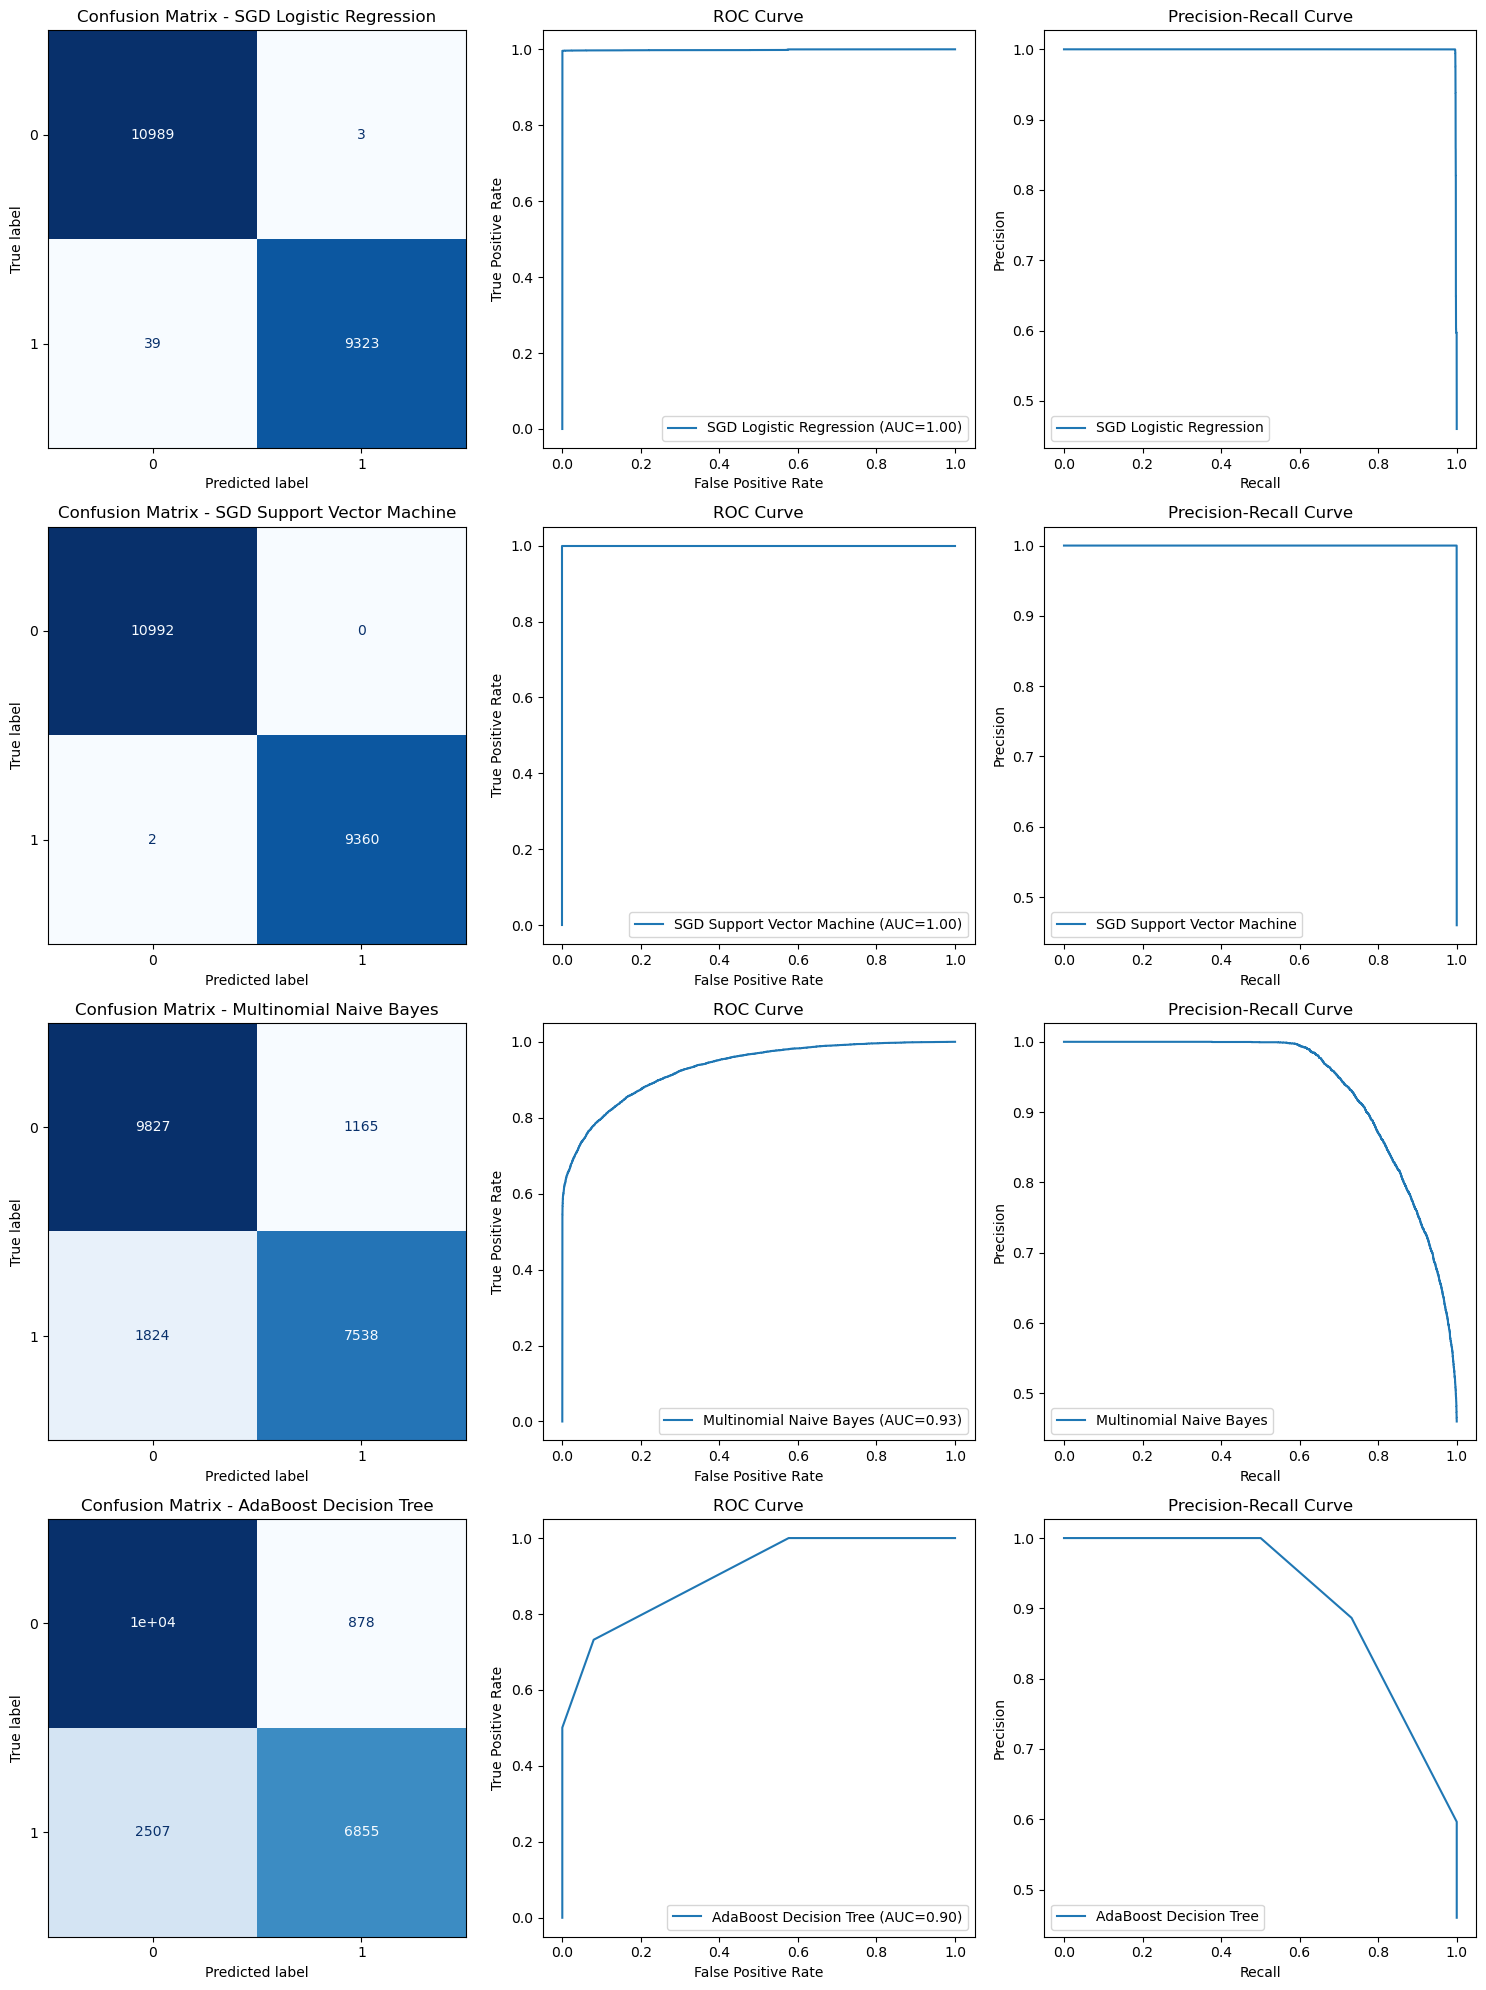

In [16]:
# Fit the models
clf_lr_pipeline.fit(X_train, y_train)
clf_svm_pipeline.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)
clf_dt_pipeline.fit(X_train, y_train)

# Create subplots for CM, ROC, and PR curves
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # 4 rows, 3 columns (CM, PR, ROC)

for i, (clf, label) in enumerate(zip([clf_lr_pipeline, clf_svm_pipeline, clf_nb, clf_dt_pipeline], clf_labels)):
    
    # Predictions
    y_test_pred = clf.predict(X_test)
    # Use predict_proba() if available; otherwise, use decision_function()
    if hasattr(clf, "predict_proba"):
        y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    else:
        y_test_prob = clf.decision_function(X_test)  # Decision scores (not probabilities)

    # Confusion Matrix
    cm_test = mt.confusion_matrix(y_test, y_test_pred)
    cm_display = mt.ConfusionMatrixDisplay(cm_test)
    axes[i, 0].set_title(f"Confusion Matrix - {label}")
    cm_display.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)

    # ROC Curve
    fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
    axes[i, 1].plot(fpr, tpr, label=f"{label} (AUC={mt.roc_auc_score(y_test, y_test_prob):.2f})")
    axes[i, 1].set_title("ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="best")
    
    # Precision-Recall Curve
    precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
    axes[i, 2].plot(recall, precision, label=f"{label}")
    axes[i, 2].set_title("Precision-Recall Curve")
    axes[i, 2].set_xlabel("Recall")
    axes[i, 2].set_ylabel("Precision")
    axes[i, 2].legend(loc="best")

    # Print final metrics for comparison
    print(f"\nPerformance Metrics for {label}:")
    print(f"  Accuracy: {mt.accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC: {mt.roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"  F1 Score: {mt.f1_score(y_test, y_test_pred):.4f}")
    print(f"  Precision: {mt.precision_score(y_test, y_test_pred):.4f}")
    print(f"  Recall: {mt.recall_score(y_test, y_test_pred):.4f}")

print("\n")
plt.tight_layout()
plt.show()


- Chosen metrics based on the fact that it is equally important to predict patients with a medication change and those without.
  - **Accuracy** – Provides a general measure of correctness, which is appropriate given the balanced classes and the need for equal weight on both outcomes.
  - **ROC AUC** – A threshold-independent metric that visualizes the trade-off between true positives and false positives across different classification thresholds, helping assess overall model discrimination.
  - **F1 Score** – Balances precision and recall, ensuring that the model is not overly biased toward one class.
  - **Precision & Recall** – Helps analyze the trade-offs between minimizing false positives (incorrectly predicted medication changes) and false negatives (missed medication changes).

- Summary of the Plotted Evaluation Metrics (Full Feature Set)  
  - **Confusion Matrix (Left):** Shows correct and incorrect predictions.  
  - **ROC Curve & AUC Score (Middle):** Assesses the model’s ability to distinguish between classes across different thresholds.  
  - **Precision-Recall (PR) Curve (Right):** Visualizes the trade-off between precision and recall.  

Takeaways: 
- SGD Logistic Regression & SGD SVM
  - Nearly perfect classification with almost no false positives or false negatives (Logistic Regression: 3/39, SVM: 0/2)
  - ROC AUC = 1.00, meaning near perfect class separation.
  - PR Curve is ideal, showing near-perfect recall and precision.
  - Near perfect result poses the question, is this real?
- Multinomial Naive Bayes (Third Model)
  - More false negatives (1,824) and false positives (1,165).
  - ROC AUC = 0.93, good but weaker class separation than the SGD models.
- AdaBoost Decision Tree (Bottom Model)
  - More false negatives (2,507) and false positives (878) than SGD models and a different balance than Naive Bayes
  - ROC AUC = 0.90, still good but slightly weaker than Naive Bayes.


#### Tuning on Dataset with Even Fewer Features

In [17]:
# Tune on a subset of of X_train the training data
# Underscores are variables returned but not needed
X_train_super_reduced_tune, _, y_train_tune, _ = train_test_split(X_train_super_reduced, y_train, train_size=0.5, stratify=y_train, random_state=1234)

print(f"Original training set size: {X_train.shape[0]}")
print(f"Subset size for tuning: {X_train_tune.shape[0]}")


print('Results for Super Reduced Dataset')

# Pipelines
clf_lr_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_lr)])
clf_svm_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_svm)])
# clf_nb # No scaling needed
clf_dt_pipeline_red = Pipeline([('preprocessor', preprocessor_reduced), ('clf', clf_dt)])

# Hyperparameter tuning for SGDClassifier (Logistic Regression with SGD)
start_time = time.time()

param_grid_lr = {
    'clf__penalty': ['l1', 'l2'], #l1 is lasso
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__eta0': [0.001, 0.01],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_lr = GridSearchCV(
    clf_lr_pipeline_red, param_grid_lr, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_lr = HalvingGridSearchCV(
#     clf_lr_pipeline_red, param_grid_lr, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,  # Uses at most ~half of training data
#     return_train_score=True, n_jobs=-1
# )
grid_lr.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nLogistic Regression (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_lr.cv_results_['param_clf__penalty'],
    grid_lr.cv_results_['param_clf__alpha'],
    grid_lr.cv_results_['param_clf__eta0'],
    grid_lr.cv_results_['param_clf__learning_rate'],
    grid_lr.cv_results_['param_clf__max_iter'],
    grid_lr.cv_results_['mean_test_accuracy'],
    grid_lr.cv_results_['mean_test_roc_auc'],
    grid_lr.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_lr.best_params_['clf__penalty']
best_alpha = grid_lr.best_params_['clf__alpha']
best_eta0 = grid_lr.best_params_['clf__eta0']
best_learning_rate = grid_lr.best_params_['clf__learning_rate']
best_max_iter = grid_lr.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for Logistic Regression (SGD) Classifier - Penalty: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")

# Update SGDClassifier with best hyperparameters
clf_lr_pipeline_red.set_params(clf__penalty=best_penalty)
clf_lr_pipeline_red.set_params(clf__alpha=best_alpha)
clf_lr_pipeline_red.set_params(clf__eta0=best_eta0)
clf_lr_pipeline_red.set_params(clf__learning_rate=best_learning_rate)
clf_lr_pipeline_red.set_params(clf__max_iter=best_max_iter)

print(f"LR Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for SGDClassifier (Support Vector Machine with SGD)
start_time = time.time()

param_grid_svm = {
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__eta0': [0.001, 0.01, 0.1],
    'clf__learning_rate': ['optimal', 'adaptive'],
    'clf__max_iter': [500]
}

grid_svm = GridSearchCV(
    clf_svm_pipeline_red, param_grid_svm, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True, n_jobs=-1
)
# grid_svm = HalvingGridSearchCV(
#     clf_svm_pipeline_red, param_grid_svm, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True, n_jobs=-1
# )
grid_svm.fit(X_train_tune, y_train_tune)

# Print accuracy and AUC for each hyperparameter combination
print("\nSVM (SGD) Classifier - Hyperparameter Performance:")
for penalty, alpha, eta0, learning_rate, max_iter, acc, auc, f1 in zip(
    grid_svm.cv_results_['param_clf__penalty'],
    grid_svm.cv_results_['param_clf__alpha'],
    grid_svm.cv_results_['param_clf__eta0'],
    grid_svm.cv_results_['param_clf__learning_rate'],
    grid_svm.cv_results_['param_clf__max_iter'],
    grid_svm.cv_results_['mean_test_accuracy'],
    grid_svm.cv_results_['mean_test_roc_auc'],
    grid_svm.cv_results_['mean_test_f1']
):
    print(f"Penalty: {penalty}, Alpha: {alpha}, eta0: {eta0}, Learning Rate: {learning_rate}, Max Iter: {max_iter}, "
          f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best hyperparameters
best_penalty = grid_svm.best_params_['clf__penalty']
best_alpha = grid_svm.best_params_['clf__alpha']
best_eta0 = grid_svm.best_params_['clf__eta0']
best_learning_rate = grid_svm.best_params_['clf__learning_rate']
best_max_iter = grid_svm.best_params_['clf__max_iter']

print(f"\nBest hyperparameters for SVM (SGD) Classifier - Penaly: {best_penalty}, Alpha: {best_alpha}, eta0: {best_eta0}, "
      f"Learning Rate: {best_learning_rate}, Max Iter: {best_max_iter}")


# Update SGDClassifier with best hyperparameters
clf_svm_pipeline_red.set_params(clf__penalty=best_penalty)
clf_svm_pipeline_red.set_params(clf__alpha=best_alpha)
clf_svm_pipeline_red.set_params(clf__eta0=best_eta0)
clf_svm_pipeline_red.set_params(clf__learning_rate=best_learning_rate)
clf_svm_pipeline_red.set_params(clf__max_iter=best_max_iter)

print(f"SVM Classifier Tuning Time: {(time.time() - start_time)/60:.2f} minutes")

    
# Hyperparameter tuning for MultinomialNB
start_time = time.time()

param_grid_nb = {
    'alpha': np.arange(0.1, 1.1, 0.1),
    'class_prior': [(0.3, 0.7), (0.4, 0.6), (0.46, 0.54), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]  # Yes=46%
}

grid_nb = GridSearchCV(
    clf_nb, param_grid_nb, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_nb = HalvingGridSearchCV(
#     clf_nb, param_grid_nb, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_nb.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nMultinomialNB - Hyperparameter Performance:")
for alpha, class_prior, acc, auc, f1 in zip(
    grid_nb.cv_results_['param_alpha'],
    grid_nb.cv_results_['param_class_prior'],
    grid_nb.cv_results_['mean_test_accuracy'],
    grid_nb.cv_results_['mean_test_roc_auc'],
    grid_nb.cv_results_['mean_test_f1']
):
    print(f"Alpha: {alpha}, Class Prior: {class_prior}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best alpha and class_prior
best_alpha = grid_nb.best_params_['alpha']
best_class_prior = grid_nb.best_params_['class_prior']
print(f"\nBest alpha for MNB: {best_alpha}, Best class prior: {best_class_prior}")

# Update NB classifier with best hyperparameters
clf_nb = MultinomialNB(alpha=best_alpha, class_prior=best_class_prior)

print(f"NB Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


# Hyperparameter tuning for AdaBoost
start_time = time.time()

param_grid_ab = {'clf__n_estimators': [50, 100, 200],
                 'clf__learning_rate': [0.1, 0.5, 1.0, 1.5]}

grid_ab = GridSearchCV(
    clf_dt_pipeline_red, param_grid_ab, cv=3, scoring=['accuracy', 'roc_auc', 'f1'], refit='accuracy',
    return_train_score=True
)
# grid_ab = HalvingGridSearchCV(
#     clf_dt_pipeline_red, param_grid_ab, cv=3, factor=2, scoring='accuracy',
#     resource="n_samples", max_resources=40000,
#     return_train_score=True
# )
grid_ab.fit(X_train_super_reduced_tune, y_train_tune)

# Print accuracy and recall for each hyperparameter combination
print("\nAdaBoost - Hyperparameter Performance:")
for n_estimators, learning_rate, acc, auc, f1 in zip(
    grid_ab.cv_results_['param_clf__n_estimators'], 
    grid_ab.cv_results_['param_clf__learning_rate'],
    grid_ab.cv_results_['mean_test_accuracy'],
    grid_ab.cv_results_['mean_test_roc_auc'],
    grid_ab.cv_results_['mean_test_f1']
):
    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

# Get best n_estimators and learning_rate
best_n_estimators = grid_ab.best_params_['clf__n_estimators']
best_learning_rate = grid_ab.best_params_['clf__learning_rate']
print(f"\nBest n_estimators for AdaBoost: {best_n_estimators}, Best learning_rate: {best_learning_rate}")

# Update AdaBoost classifier with best n_estimators
clf_dt_pipeline_red.set_params(clf__n_estimators=best_n_estimators)
clf_dt_pipeline_red.set_params(clf__learning_rate=best_learning_rate)

print(f"AdaBoost Tuning Time: {(time.time() - start_time)/60:.2f} minutes")


Original training set size: 81412
Subset size for tuning: 40706
Results for Super Reduced Dataset

Logistic Regression (SGD) Classifier - Hyperparameter Performance:
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9957, AUC: 0.9974, F1: 0.9953
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9933, AUC: 0.9965, F1: 0.9927
Penalty: l1, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9801, AUC: 0.9930, F1: 0.9780
Penalty: l2, Alpha: 0.0001, eta0: 0.001, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9802, AUC: 0.9926, F1: 0.9781
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9957, AUC: 0.9974, F1: 0.9953
Penalty: l2, Alpha: 0.0001, eta0: 0.01, Learning Rate: optimal, Max Iter: 500, Accuracy: 0.9933, AUC: 0.9965, F1: 0.9927
Penalty: l1, Alpha: 0.0001, eta0: 0.01, Learning Rate: adaptive, Max Iter: 500, Accuracy: 0.9928, AUC:

#### Cross-Validation with Super Reduced Dataset

In [18]:
start_time_total = time.time()  # Track total time

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Dictionary to store model training times and accuracy scores
cv_times = {}
cv_accuracy_scores = {}  # Store accuracy scores for each model

# Cross-validation: Recall, Accuracy, F1
print("\n10-fold Cross-Validation Metrics:\n")
for clf, label in zip([clf_lr_pipeline_red, clf_svm_pipeline_red, clf_nb, clf_dt_pipeline_red], clf_labels):
    
    start_time = time.time()  # Start timing for the model
    
    # Compute and store accuracy scores
    accuracy_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_accuracy_scores[label] = accuracy_scores  # Store for later use
    
    # Compute and display AUC and F1 scores
    roc_auc_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(estimator=clf, X=X_train_super_reduced, y=y_train, cv=skf, scoring='f1', n_jobs=-1)

    end_time = time.time()  # End timing
    
    # Store elapsed time in minutes
    cv_times[label] = (end_time - start_time) / 60 
    
    print(f"{label}:")
    print(f"  CV Accuracy: {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    print(f"  CV AUC: {roc_auc_scores.mean():.3f} (+/- {roc_auc_scores.std():.3f})")
    print(f"  CV F1 Score: {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})\n")


# Print Cross-Validation Timing Per Model
print("\nCross-Validation Time per Model (in minutes):")
for model, time_taken in cv_times.items():
    print(f"{model}: {time_taken:.2f} minutes")

# Print Total Time Taken
end_time_total = time.time()
print(f"\nTotal Elapsed Time for Cross-Validation: {(end_time_total - start_time_total)/60:.2f} minutes")


10-fold Cross-Validation Metrics:

SGD Logistic Regression:
  CV Accuracy: 0.996 (+/- 0.001)
  CV AUC: 0.998 (+/- 0.000)
  CV F1 Score: 0.996 (+/- 0.001)

SGD Support Vector Machine:
  CV Accuracy: 0.997 (+/- 0.001)
  CV AUC: 0.998 (+/- 0.000)
  CV F1 Score: 0.996 (+/- 0.001)

Multinomial Naive Bayes:
  CV Accuracy: 0.810 (+/- 0.004)
  CV AUC: 0.735 (+/- 0.008)
  CV F1 Score: 0.741 (+/- 0.007)

AdaBoost Decision Tree:
  CV Accuracy: 0.966 (+/- 0.002)
  CV AUC: 0.975 (+/- 0.002)
  CV F1 Score: 0.961 (+/- 0.003)


Cross-Validation Time per Model (in minutes):
SGD Logistic Regression: 0.03 minutes
SGD Support Vector Machine: 0.04 minutes
Multinomial Naive Bayes: 0.01 minutes
AdaBoost Decision Tree: 0.07 minutes

Total Elapsed Time for Cross-Validation: 0.14 minutes


#### Statistical Comparison of Models

In [19]:
# Extract accuracy scores from dictionary
lr_acc = cv_accuracy_scores["SGD Logistic Regression"]
svm_acc = cv_accuracy_scores["SGD Support Vector Machine"]
nb_acc = cv_accuracy_scores["Multinomial Naive Bayes"]
dt_acc = cv_accuracy_scores["AdaBoost Decision Tree"]

# Define all model pairs for pairwise comparisons
model_pairs = [
    ("SGD Logistic Regression", "SGD Support Vector Machine", lr_acc, svm_acc),
    ("SGD Logistic Regression", "Multinomial Naive Bayes", lr_acc, nb_acc),
    ("SGD Logistic Regression", "AdaBoost Decision Tree", lr_acc, dt_acc),
    ("SGD Support Vector Machine", "Multinomial Naive Bayes", svm_acc, nb_acc),
    ("SGD Support Vector Machine", "AdaBoost Decision Tree", svm_acc, dt_acc),
    ("Multinomial Naive Bayes", "AdaBoost Decision Tree", nb_acc, dt_acc),
]

# Perform paired t-tests
p_values = []
t_stats = []

print("\nPairwise t-test results:")
for name1, name2, acc1, acc2 in model_pairs:
    t_stat, p_val = ttest_rel(acc1, acc2)
    t_stats.append(t_stat)
    p_values.append(p_val)
    print(f"{name1} vs {name2}: t = {t_stat:.3f}, p = {p_val:.5f}")

# Apply Bonferroni correction
_, p_corrected_bonferroni, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

print("\nBonferroni-corrected p-values:")
for i, (name1, name2, _, _) in enumerate(model_pairs):
    print(f"{name1} vs {name2}: p = {p_corrected_bonferroni[i]:.5f}")

# === Tukey's HSD Test ===
# Combine all accuracy scores into a single array
all_scores = np.concatenate([lr_acc, svm_acc, nb_acc, dt_acc])

# Create labels for each model (repeated for each fold)
model_labels = (["SGD Logistic Regression"] * len(lr_acc) +
                ["SGD Support Vector Machine"] * len(svm_acc) +
                ["Multinomial Naive Bayes"] * len(nb_acc) +
                ["AdaBoost Decision Tree"] * len(dt_acc))

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_scores, model_labels, alpha=0.05)

print("\nTukey's HSD Test Results:")
print(tukey_results)



Pairwise t-test results:
SGD Logistic Regression vs SGD Support Vector Machine: t = -7.250, p = 0.00005
SGD Logistic Regression vs Multinomial Naive Bayes: t = 154.749, p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: t = 37.336, p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: t = 150.741, p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: t = 38.209, p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: t = -145.486, p = 0.00000

Bonferroni-corrected p-values:
SGD Logistic Regression vs SGD Support Vector Machine: p = 0.00029
SGD Logistic Regression vs Multinomial Naive Bayes: p = 0.00000
SGD Logistic Regression vs AdaBoost Decision Tree: p = 0.00000
SGD Support Vector Machine vs Multinomial Naive Bayes: p = 0.00000
SGD Support Vector Machine vs AdaBoost Decision Tree: p = 0.00000
Multinomial Naive Bayes vs AdaBoost Decision Tree: p = 0.00000

Tukey's HSD Test Results:
                   Multiple Comparison of Means - Tukey HSD

Same results as found for the dataset including more features:
- Paired t-tests with Bonferroni correction found a statistically significant difference between all models.
- Tukey’s HSD Test did not find a significant difference between Logistic Regression and SVM. It confirmed Naive Bayes and AdaBoost were significantly different from the SGD-based models.


#### Model Evaluation with Super Reduced Dataset


Performance Metrics for SGD Logistic Regression:
  Accuracy: 0.9961
  ROC AUC: 0.9977
  F1 Score: 0.9958
  Precision: 1.0000
  Recall: 0.9916

Performance Metrics for SGD Support Vector Machine:
  Accuracy: 0.9966
  ROC AUC: 0.9976
  F1 Score: 0.9962
  Precision: 1.0000
  Recall: 0.9925

Performance Metrics for Multinomial Naive Bayes:
  Accuracy: 0.8107
  ROC AUC: 0.7349
  F1 Score: 0.7409
  Precision: 0.9998
  Recall: 0.5885

Performance Metrics for AdaBoost Decision Tree:
  Accuracy: 0.9689
  ROC AUC: 0.9746
  F1 Score: 0.9650
  Precision: 1.0000
  Recall: 0.9323




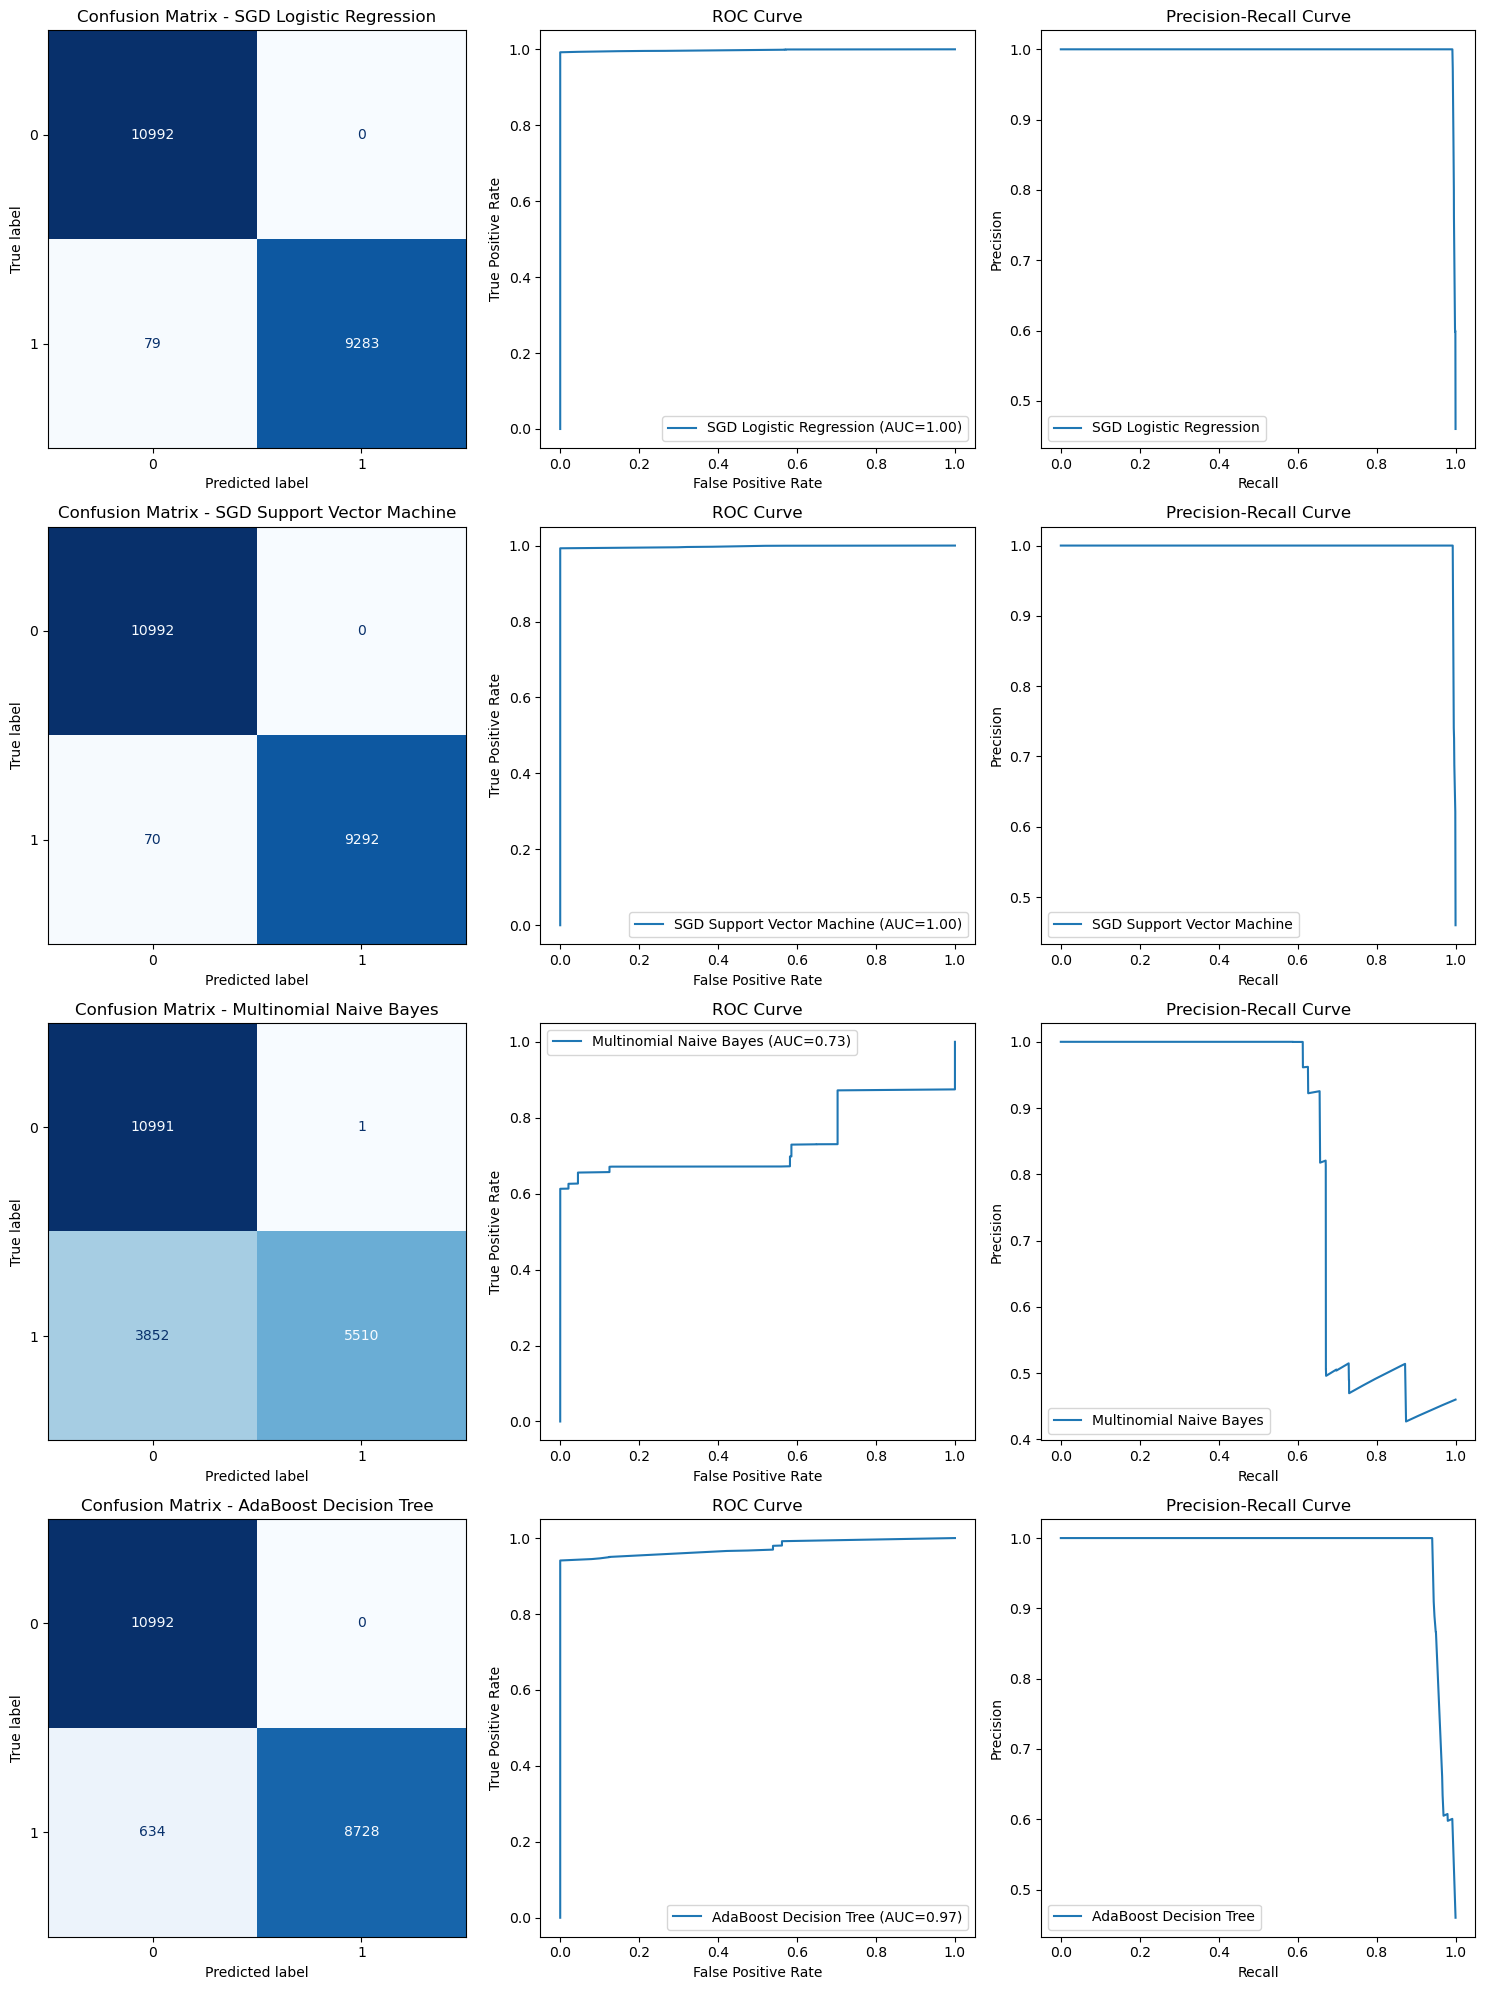

In [20]:
# Fit the models
clf_lr_pipeline_red.fit(X_train_super_reduced, y_train)
clf_svm_pipeline_red.fit(X_train_super_reduced, y_train)
clf_nb.fit(X_train_super_reduced, y_train)
clf_dt_pipeline_red.fit(X_train_super_reduced, y_train)

# Create subplots for CM, ROC, and PR curves
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # 4 rows, 3 columns (CM, PR, ROC)

for i, (clf, label) in enumerate(zip([clf_lr_pipeline_red, clf_svm_pipeline_red, clf_nb, clf_dt_pipeline_red], clf_labels)):
    
    # Predictions
    y_test_pred = clf.predict(X_test_super_reduced)
    # Use predict_proba() if available; otherwise, use decision_function()
    if hasattr(clf, "predict_proba"):
        y_test_prob = clf.predict_proba(X_test_super_reduced)[:, 1]  # Probabilities for positive class
    else:
        y_test_prob = clf.decision_function(X_test_super_reduced)  # Decision scores (not probabilities)
    
    # Confusion Matrix
    cm_test = mt.confusion_matrix(y_test, y_test_pred)
    cm_display = mt.ConfusionMatrixDisplay(cm_test)
    axes[i, 0].set_title(f"Confusion Matrix - {label}")
    cm_display.plot(ax=axes[i, 0], cmap="Blues", colorbar=False)

    # ROC Curve
    fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
    axes[i, 1].plot(fpr, tpr, label=f"{label} (AUC={mt.roc_auc_score(y_test, y_test_prob):.2f})")
    axes[i, 1].set_title("ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="best")
    
    # Precision-Recall Curve
    precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
    axes[i, 2].plot(recall, precision, label=f"{label}")
    axes[i, 2].set_title("Precision-Recall Curve")
    axes[i, 2].set_xlabel("Recall")
    axes[i, 2].set_ylabel("Precision")
    axes[i, 2].legend(loc="best")

    # Print final metrics for comparison
    print(f"\nPerformance Metrics for {label}:")
    print(f"  Accuracy: {mt.accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC: {mt.roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"  F1 Score: {mt.f1_score(y_test, y_test_pred):.4f}")
    print(f"  Precision: {mt.precision_score(y_test, y_test_pred):.4f}")
    print(f"  Recall: {mt.recall_score(y_test, y_test_pred):.4f}")

print(f"\n")
plt.tight_layout()
plt.show()


Takeaways:
- SGD Logistic Regression & SGD SVM
  - Nearly perfect classification with no false positives and very few false negatives.  
    - Logistic Regression: 0 False Positives / 79 False Negatives.  
    - SVM: 0 False Positives / 70 False Negatives.  
  - ROC AUC = 1.00, near-perfect class separation.  
  - PR Curve is ideal, showing near-perfect recall and precision.  
- Multinomial Naive Bayes
  - More false negatives (3,852) compared to SGD models.
  - ROC AUC = 0.73, lower than the 0.93 when more variables were included.
- AdaBoost Decision Tree
  - Fewer false negatives (634) than Naive Bayes or the AdaBoost including more features. No false positives.
  - ROC AUC = 0.97 higher than the 0.90 using more features.
- SGD Logistic Regression and SVM consistently performed best, with SVM slightly outperforming LR in accuracy when more features were included.
- Reducing features improved AdaBoost significantly (from 83.3% to 96.9% accuracy), likely by reducing overfitting improving model generalization.
- Logistic Regression was much faster than SVM and AdaBoost.
- Naive Bayes was the fastest model but consistently the weakest. Surprisingly, its performance dropped when reducing features.
- All except the Naive Bayes model performed similarly or better after reducing the number of features from those selected by feature selection to eight medication variables. 
- All models predicted the negative class better than the positive class, as indicated by the higher number of false negatives compared to false positives, leading to slightly higher precision than recall.
- All of the models performed similarly comparing the metrics from cross-validation on the training set and the metrics from the heldout testing set.

**Recommendation**: Though SVM slightly outperformed Logistic Regression and AdaBoost Decision Tree models, we would recommend the Logistic Regression model for the following reasons.
  1. It is faster and computationally more efficient.
  2. It is very interpretable.
  3. It performs well with both a reduced dataset of very important features and a more expanded dataset with feature of lower importance.
  4. It generalizes well, performing consistently well using cross-validation on training data and when evaluated on unseen testing data.
     

## Data Preparation: Regression Task

Our second task is predicting the number of days a patient will be hospitalized, the variable `time_in_hospital`.


#### Preprocessing: Separating the Response Variable, Encoding and Scaling

In [21]:
# Get a copy of the data prior preprocessing for classification
df2 = df_clean.copy()

# Extract response variable
y_time = df2['time_in_hospital']
X_time = df2.drop(columns=['time_in_hospital'])

# Define categorical and numerical feature subsets
categorical_cols = X_time.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_time.select_dtypes(include=['int64', 'float64']).columns

# One-Hot Encoding categorical variables
X_time_encoded = pd.get_dummies(X_time, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues

# Define the preprocessing pipeline
# Apply StandardScaler only to numerical columns while keeping categorical (one-hot encoded) features unchanged
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_cols)], remainder='passthrough')



- The response variable `time_in_hospital` was separated from the explanatory features.
- Categorical variables were encoded, and scaling was applied to numerical variables for appropriate models.
  

#### Review Summary Statistics of the Response


Summary Statistics for 'time_in_hospital':
count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64


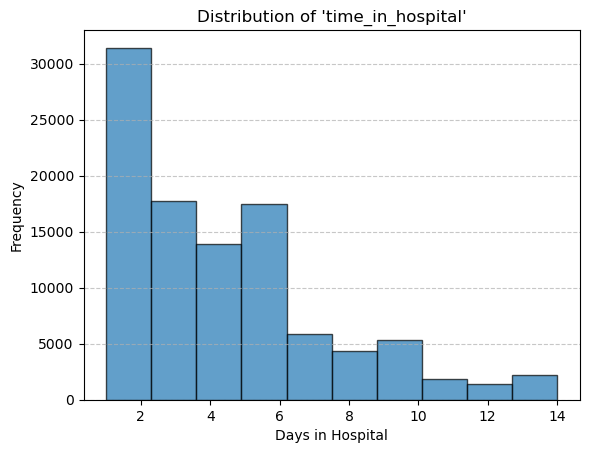

In [22]:
# Display summary statistics for the response variable
y_summary = y_time.describe()

# Print summary statistics
print("\nSummary Statistics for 'time_in_hospital':")
print(y_summary)

# Plot distribution of response variable
plt.figure()
plt.hist(y_time, edgecolor='black', alpha=0.7)
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.title("Distribution of 'time_in_hospital'")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- The response variable is right skewed.
  

#### Strategy for Performance Validation

- The dataset was split into training and holdout sets (80/20 split).
- Lasso feature selection was performed with 5-fold CV.
- Hyperparameter tuning was conducted using different approaches for efficiency:
  - 5-fold CV was used for models where `GridSearchCV` was implemented.
  - 7-fold CV was used for models where `RandomizedSearchCV` was implemented, allowing a more computationally efficient search over a wider hyperparameter space.
- 10-fold CV was performed with tuned parameters to statistically compare the MSE of the models.
- The holdout test set (20%) was reserved for final model evaluation after tuning.
- Given the dataset size (~100,000 records), an 80/20 split was chosen to:
  1. Ensure sufficient samples for training and validation, while leaving enough data for an unbiased test set.
  2. Preserve representation across categories, ensuring the training set captures the variance in categorical features.


#### Split the Data into a Training and Holdout Set Prior to Feature Selection

In [23]:
# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_time_encoded, y_time, test_size=0.2, random_state=1234)


#### Feature Selection

In [24]:
# ----- LASSO Feature Selection -----
start_time = time.time()

lasso_selector = LassoCV(cv=5, random_state=1234)

# Create a pipeline with preprocessing and LASSO
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', lasso_selector)
])

# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Retrieve feature names after transformation
feature_names = numerical_cols.tolist() + [col for col in X_train.columns if col not in numerical_cols]

# Select features with non-zero coefficients
lasso_selected_features = [feature_names[i] for i in range(len(feature_names)) if lasso_selector.coef_[i] != 0]

print(f"LASSO time: {(time.time() - start_time)/60:.2f} minutes")

# ----- Random Forest Feature Selection -----
start_time = time.time()

rf_selector = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_selector.fit(X_train, y_train)

# Get feature importances and select top features
feature_importances = pd.Series(rf_selector.feature_importances_, index=X_train.columns)
rf_selected_features = feature_importances[feature_importances > np.percentile(feature_importances, 75)].index.tolist()  # Top 25% features

print(f"RF time: {(time.time() - start_time)/60:.2f} minutes")

# - `lasso_selected_features` is the list of features selected by LASSO
# - `rf_selected_features` is the list of features selected by Random Forest
# - `X_time` is the original dataset before encoding
# - `categorical_cols` and `numerical_cols` are already defined

# Convert feature lists to DataFrames for processing
lasso_df = pd.DataFrame({'Feature': lasso_selected_features})
rf_df = pd.DataFrame({'Feature': rf_selected_features})

# ----- Extract Original Variable Names for LASSO -----
lasso_numeric = lasso_df['Feature'][lasso_df['Feature'].isin(numerical_cols)]
lasso_categorical = lasso_df['Feature'][~lasso_df['Feature'].isin(numerical_cols)]
lasso_original_categorical = lasso_categorical.str.replace(r'_[^_]+$', '', regex=True)  # Remove one-hot encoding suffixes

# Combine numeric and cleaned categorical features
lasso_unique_features = pd.concat([lasso_numeric, lasso_original_categorical]).unique()

# ----- Extract Original Variable Names for Random Forest -----
rf_numeric = rf_df['Feature'][rf_df['Feature'].isin(numerical_cols)]
rf_categorical = rf_df['Feature'][~rf_df['Feature'].isin(numerical_cols)]
rf_original_categorical = rf_categorical.str.replace(r'_[^_]+$', '', regex=True)

# Combine numeric and cleaned categorical features
rf_unique_features = pd.concat([rf_numeric, rf_original_categorical]).unique()

# ----- Find Common & Unused Features -----
dataset_features = pd.Series(X_time.columns)  # Original dataset BEFORE encoding

# Features selected by both LASSO & RF
common_features = pd.Series(list(set(lasso_unique_features) & set(rf_unique_features)))

# Features in dataset but not selected by either method
unused_features = dataset_features[~dataset_features.isin(pd.concat([pd.Series(lasso_unique_features), pd.Series(rf_unique_features)]))]

# Print Results
print("\nLASSO Unique Selected Features (Original Variables):")
print(lasso_unique_features)

print("\nRandom Forest Unique Selected Features (Original Variables):")
print(rf_unique_features)

print("\nCommon Features Selected by Both LASSO and RF:")
print(common_features.to_list())

print("\nUnused Features (Present in Dataset but NOT Selected by LASSO or RF):")
print(unused_features.to_list())


LASSO time: 0.41 minutes
RF time: 7.45 minutes

LASSO Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'glimepiride' 'glipizide'
 'glyburide' 'pioglitazone' 'rosiglitazone' 'insulin' 'change'
 'diabetesMed' 'readmitted']

Random Forest Unique Selected Features (Original Variables):
['num_lab_procedures' 'num_procedures' 'num_medications'
 'number_outpatient' 'number_emergency' 'number_inpatient'
 'number_diagnoses' 'race' 'gender' 'age' 'admission_type_id'
 'discharge_disposition_id' 'admission_source_id' 'payer_code'
 'medical_specialty' 'diag_1' 'diag_2' 'diag_3' 'max_glu_serum'
 'A1Cresult' 'metformin' 'repaglinide' 'nateglinide' 'glimepiride'
 'glipizide'

#### Create a Reduced Dataset with Important Variables

In [25]:
# Train/test split was already created. Do this to avoid leakage.

# Identify encoded features corresponding to lasso-selected original features
selected_encoded_features = [col for col in X_train.columns if any(feature in col for feature in lasso_unique_features)]

# Create a Reduced Dataset with Encoded Features
X_train_selected = X_train[selected_encoded_features].copy()
X_test_selected = X_test[selected_encoded_features].copy()  # Ensure same columns in test set

# Ensure train and test have the same columns (Test set may lack some categories)
X_test_selected = X_test_selected.reindex(columns=X_train_selected.columns, fill_value=0)

# Final check
print("Final Training Shape:", X_train_selected.shape)
print("Final Testing Shape:", X_test_selected.shape)


Final Training Shape: (81412, 2362)
Final Testing Shape: (20354, 2362)



- Feature selection was performed using both LASSO penalized regression and Random Forest Regression to identify the most important variables.  
- The selected features were highly similar between both methods, indicating consistency in variable importance.  
- The LASSO-selected feature set was chosen as the final set because it resulted in a more reduced set of features, helping simplify the model while retaining predictive strength.


## Modeling and Evaluation: Regression Task

#### **Define Regressors**

We tested five regression models:  
1. **LASSO Regression (LassoCV)**  
   - Selected for its ability to perform feature selection by penalizing less important variables, leading to a simpler, more interpretable model.  
2. **Random Forest Regressor**  
   - Chosen for its ability to capture complexity and for being less sensitive to outliers.  
   - `RandomizedSearchCV` was used for hyperparameter tuning to improve efficiency.  
3. **Support Vector Regression (SVR)**  
   - Included only during hyperparameter tuning to test how a kernel-based approach compared to the linear models.  
   - Subsampling was used to improve computational efficiency.  
4. **Stochastic Gradient Descent Regressor (SGDRegressor)**  
   - Chosen as a alternative to standard linear regression for use with a medium to large dataset.  
5. **XGBoost Regressor**  
   - Included for its high flexibility and efficiency.  
   - `RandomizedSearchCV` was used for hyperparameter tuning to improve efficiency.  


#### **Tune Hyperparameters**  

Mean squared error (MSE) (or negative MSE) was used as the tuning metric.

For each model, hyperparameters were tuned to improve performance. Key parameters included:
- **LASSO Regression (LassoCV)**  
  - `alpha`: Regularization strength (controls the penalty on large coefficients; smaller values allow more flexibility but increase overfitting risk, while larger values result in stronger regularization, reducing complexity).  
- **Random Forest Regressor**  
  - `n_estimators`: Number of trees in the forest (higher values improve stability but increase training time).  
  - `max_depth`: Limits tree depth to prevent overfitting (deeper trees capture more patterns but risk capturing noise).  
  - `min_samples_split`: Minimum samples required to split a node (higher values encourage simpler trees, reducing overfitting).  
  - `min_samples_leaf`: Minimum samples required per leaf node (larger values prevent overfitting).  
  - `max_features`: Controls the number of features considered per split (`'sqrt'` balances model diversity and accuracy).  
- **Support Vector Regression (SVR)**
  - `C`: Regularization parameter (higher values allow more flexibility but risk overfitting, while lower values enforce stricter margins).  
  - `gamma`: Controls the amount of influence of each data point with higher resulting in greater influence and complexity (`scale` uses feature variance, `auto` uses 1/#features).  
  - `epsilon`: Defines a margin of tolerance for small prediction errors (higher values simplify the model but reduce sensitivity).  
  - RBF kernel was selected to allow for non-linear regression modeling.
- **Stochastic Gradient Descent Regressor (SGDRegressor)**
  - `alpha`: Regularization strength (higher values reduce complexity but risk underfitting, while lower values can overfit).  
  - `max_iter`: Maximum number of iterations for convergence.  
  - `tol`: Stopping criteria (smaller values force additional iterations but increasing computation, larger values result in faster fitting but may stop before best solution is reached).  
  - `learning_rate`: Controls step size per iteration (`constant` is fixed, `optimal` adjusts dynamically, `invscaling` reduces learning rate over time).  
  - Early stopping was enabled to prevent unnecessary training once performance stabilizes because max iterations was set high to ensure convergence.
- **XGBoost Regressor**
  - `n_estimators`: Number of boosting rounds (higher values improve performance but risk overfitting).  
  - `max_depth`: Limits the depth of trees (lower values prevent overfitting, higher values may capture complex relationships).  
  - `learning_rate`: Controls the contribution of each weak learner (lower values require more boosting rounds, higher values can lead to overfitting).  
  - `subsample`: Proportion of data used per boosting round (lower values reduce overfitting by adding randomness).  


#### Hyperparameter Tuning

In [26]:
# ---- Hyperparameter Tuning for LASSO ----
start_time = time.time()

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], cv=5, random_state=1234)) # Use LassoCV instead of GridSearch
])

lasso_pipeline.fit(X_train_selected, y_train)

# Get best alpha directly from LassoCV
best_alpha = lasso_pipeline.named_steps['reg'].alpha_
print(f"\nBest Alpha for LASSO: {best_alpha}")

print(f"LASSO tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for Random Forest ----
start_time = time.time()

rf_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [2, 5],  
    'max_features': ['sqrt']  
}

# Use RandomizedSearchCV for efficiency
grid_rf = RandomizedSearchCV(RandomForestRegressor(random_state=1234), 
                             param_distributions=rf_grid, n_iter=7, cv=5, 
                             scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)

# Get best RF parameters
best_rf_params = grid_rf.best_params_
print(f"\nBest Parameters for Random Forest: {best_rf_params}")

print(f"RF tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SVR (RBF) ----
# For comparison with SGDRegressor (linear), RBF is computationally too expensive with full dataset
start_time = time.time()

svr_sample = X_train_selected.sample(n=min(5000, len(X_train_selected)), random_state=1234)
y_svr_sample = y_train.loc[svr_sample.index]

param_grid_svr = {
    'reg__C': [0.1, 1, 10],
    'reg__gamma': ['scale', 'auto'],
    'reg__epsilon': [0.1, 0.2, 0.5]
}

svr_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SVR(kernel='rbf'))])
grid_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
grid_svr.fit(svr_sample, y_svr_sample)

# Extract best parameters
best_C = grid_svr.best_params_['reg__C']
best_epsilon = grid_svr.best_params_['reg__epsilon']
print(f"\nBest SVR Parameters: C={best_C}, epsilon={best_epsilon}, Kernel=rbf")
print(f"SVR tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for SGDRegressor----
start_time = time.time()

param_grid_sgd = {
    'reg__alpha': [0.0001, 0.001, 0.01, 0.1],
    'reg__max_iter': [10000, 20000],
    'reg__tol': [1e-2, 1e-3],
    'reg__learning_rate': ['constant', 'optimal', 'invscaling']
}

sgd_pipeline = Pipeline([('preprocessor', preprocessor), ('reg', SGDRegressor(random_state=1234, early_stopping=True))])
grid_sgd = GridSearchCV(sgd_pipeline, param_grid_sgd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_sgd.fit(svr_sample, y_svr_sample) # Use the same sample of 5000 as used for tuning the SVR

best_sgd_params = grid_sgd.best_params_
print(f"\nBest Parameters for SGDRegressor: {best_sgd_params}")
print(f"SGDRegressor tuning time: {(time.time() - start_time)/60:.2f} minutes")


# ---- Hyperparameter Tuning for XGBoost ----
# Preprocessing fixes
# Ensure column names are strings
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# # Ensure y_train is a 1D array
# y_train = y_train.ravel()

start_time = time.time()

xgb_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_xgb = RandomizedSearchCV(XGBRegressor(tree_method='hist', random_state=1234), 
                              param_distributions=xgb_grid, n_iter=7, cv=5, 
                              scoring='neg_mean_squared_error')
grid_xgb.fit(X_train_selected, y_train)

# Get best XGBoost parameters
best_xgb_params = grid_xgb.best_params_
print(f"\nBest Parameters for XGBoost: {best_xgb_params}")
print(f"XGBoost tuning time: {(time.time() - start_time)/60:.2f} minutes")



Best Alpha for LASSO: 0.0001
LASSO tuning time: 0.97 minutes

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
RF tuning time: 1.53 minutes

Best SVR Parameters: C=10, epsilon=0.5, Kernel=rbf
SVR tuning time: 5.26 minutes

Best Parameters for SGDRegressor: {'reg__alpha': 0.001, 'reg__learning_rate': 'invscaling', 'reg__max_iter': 10000, 'reg__tol': 0.001}
SGDRegressor tuning time: 0.12 minutes

Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}
XGBoost tuning time: 2.64 minutes


#### Hyperparameter Tuning Details

In [27]:
# ---- Display LASSO Tuning Results ----
lasso_cv = lasso_pipeline.named_steps['reg']  # Extract the LassoCV model

lasso_results = pd.DataFrame({
    'Alpha': lasso_cv.alphas_,
    'Mean MSE': lasso_cv.mse_path_.mean(axis=1),  
    'Std MSE': lasso_cv.mse_path_.std(axis=1)  
})

lasso_results.sort_values(by='Mean MSE', ascending=True, inplace=True)  # Lower MSE is better
print("\nLASSO Hyperparameter Tuning Results:")
print(lasso_results)


# ---- Display Random Forest Tuning Results ----
rf_results = pd.DataFrame(grid_rf.cv_results_)
rf_results = rf_results[[
    'param_n_estimators', 'param_max_depth',
    'param_min_samples_split', 'param_min_samples_leaf',
    'param_max_features', 'mean_test_score', 'std_test_score'
]]
rf_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
rf_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  # Higher neg MSE is better
print("\nRandom Forest Hyperparameter Tuning Results:")
print(rf_results)


# ---- Display SVR Tuning Results ----
svr_results = pd.DataFrame(grid_svr.cv_results_)
svr_results = svr_results[[
    'param_reg__C', 'param_reg__gamma', 'param_reg__epsilon',
    'mean_test_score', 'std_test_score'
]]
svr_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
svr_results.sort_values(by='Mean MSE', ascending=False, inplace=True)  
print("\nSVR Hyperparameter Tuning Results:")
print(svr_results)


# ---- Display SGDRegressor Tuning Results ----
sgd_results = pd.DataFrame(grid_sgd.cv_results_)
sgd_results = sgd_results[[
    'param_reg__alpha', 'param_reg__max_iter', 'param_reg__tol', 'param_reg__learning_rate',
    'mean_test_score', 'std_test_score'
]]
sgd_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
sgd_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nSGDRegressor Hyperparameter Tuning Results:")
print(sgd_results)


# ---- Display XGBoost Tuning Results ----
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
xgb_results = xgb_results[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample',
    'mean_test_score', 'std_test_score'
]]
xgb_results.rename(columns={'mean_test_score': 'Mean MSE', 'std_test_score': 'Std MSE'}, inplace=True)
xgb_results.sort_values(by='Mean MSE', ascending=False, inplace=True)
print("\nXGBoost Hyperparameter Tuning Results:")
print(xgb_results)



LASSO Hyperparameter Tuning Results:
      Alpha  Mean MSE   Std MSE
6    0.0001  4.922157  0.061825
5    0.0010  5.006710  0.065134
4    0.0100  5.466042  0.073354
3    0.1000  6.520046  0.097922
2    1.0000  7.997807  0.105850
0  100.0000  8.937581  0.105310
1   10.0000  8.937581  0.105310

Random Forest Hyperparameter Tuning Results:
   param_n_estimators param_max_depth  param_min_samples_split  \
6                 100            None                        5   
2                 100            None                        5   
3                  50              20                       10   
4                 200              20                       10   
1                  50              20                       10   
5                  50              10                       10   
0                 100              10                       10   

   param_min_samples_leaf param_max_features  Mean MSE   Std MSE  
6                       2               sqrt -5.586330  0.096752

#### Cross-Validate Regression Models

In [28]:
# Clean best parameters to remove the "reg__" prefix
best_sgd_params_cleaned = {k.replace("reg__", ""): v for k, v in best_sgd_params.items()}

# Define best-tuned models with corrected parameters
models = {
    "LASSO Regression": Lasso(alpha=best_alpha, random_state=1234),
    "Random Forest Regression": RandomForestRegressor(**best_rf_params, random_state=1234),
    "SGD Regression": SGDRegressor(**best_sgd_params_cleaned, random_state=1234),
    "XGBoost": XGBRegressor(**best_xgb_params, tree_method='hist', random_state=1234)
}

# Define 10-fold cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1234)

# Perform CV for each model and store MSE scores
cv_mse_scores = {}
for name, model in models.items():
    mse_scores = -cross_val_score(model, X_train_selected, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_mse_scores[name] = mse_scores
    print(f"\n{name} 10-Fold CV MSE Scores: {mse_scores}")



LASSO Regression 10-Fold CV MSE Scores: [4.8755231  4.90532026 4.95241657 5.02746912 5.00917965 4.81934181
 5.11395915 4.68981783 4.88224079 4.81671992]

Random Forest Regression 10-Fold CV MSE Scores: [5.50320506 5.59091167 5.5530301  5.72141489 5.57060659 5.42561055
 5.64177334 5.39403829 5.54358504 5.51895066]

SGD Regression 10-Fold CV MSE Scores: [ 5.83459237 10.60795108  5.64682685  6.5272637   5.57556209  7.6926736
  6.05899605  5.56842417  5.27124945  5.39333436]

XGBoost 10-Fold CV MSE Scores: [4.68114614 4.74809742 4.71482468 4.81430912 4.78221083 4.59746981
 4.86265707 4.57806444 4.70219517 4.63741684]


#### Fit and Evaluate Regression Models on the Holdout Set

In [31]:
start_time_total = time.time()  # Track total time

# Define model labels
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Store training and prediction times
model_times = {"Training Time (min)": {}, "Prediction Time (sec)": {}}


# ---- Update pipelines with with best parameters ----
# Update Lasso pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', Lasso(alpha=best_alpha, random_state=1234))  # Use Lasso (not LassoCV)
])

# Update RF model with modified best parameters, set n_estimators manually (error/time tradeoff isn't worth it)
# Remove "reg__" prefix from best parameters
best_rf_params_cleaned = {k.replace("reg__", ""): v for k, v in best_rf_params.items()}
best_rf_params_cleaned['n_estimators'] = 50  # Manually reduce to 50 trees
rf_model = RandomForestRegressor(**best_rf_params_cleaned, random_state=1234)  # No pipeline needed

# Update SGDRegressor pipeline
best_sgd_params = {k.replace("reg__", ""): v for k, v in grid_sgd.best_params_.items()}
best_sgd_params['random_state'] = 1234  # Ensure reproducibility
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', SGDRegressor(**best_sgd_params))
])

# Update XGB model
xgb_best_params = {k.replace("reg__", ""): v for k, v in best_xgb_params.items()}
xgb_model = XGBRegressor(**xgb_best_params, tree_method='hist', random_state=1234)


# ---- Preprocessing Fixes for XGBoost ----
X_train_selected.columns = X_train_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
X_test_selected.columns = X_test_selected.columns.astype(str).str.replace(r"[^\w]", "_", regex=True)
# y_train = y_train.ravel()  # Ensure y_train is a 1D array


# ---- Fit the tuned models ----
start_time = time.time()
lasso_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["LASSO Regression"] = (time.time() - start_time) / 60  # Convert to minutes

start_time = time.time()
rf_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["Random Forest Regression"] = (time.time() - start_time) / 60

start_time = time.time()
sgd_pipeline.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["SGD Regression"] = (time.time() - start_time) / 60

start_time = time.time()
xgb_model.fit(X_train_selected, y_train)
model_times["Training Time (min)"]["XGBoost"] = (time.time() - start_time) / 60


# ---- Make predictions ----
start_time = time.time()
y_test_pred_lasso = lasso_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["LASSO Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_rf = rf_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["Random Forest Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_sgd = sgd_pipeline.predict(X_test_selected)
model_times["Prediction Time (sec)"]["SGD Regression"] = time.time() - start_time

start_time = time.time()
y_test_pred_xgb = xgb_model.predict(X_test_selected)
model_times["Prediction Time (sec)"]["XGBoost"] = time.time() - start_time


# Function for evaluating models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    return {"Model": model_name, "MSE": mse, "MAE": mae, "R²": r2}

# Store results
results = []
for y_pred, label in zip([y_test_pred_lasso, y_test_pred_rf, y_test_pred_sgd, y_test_pred_xgb], reg_labels):
    results.append(evaluate_model(y_test, y_pred, label))

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df)

# Print training, prediction and total times 
print("\nModel Training Times (in minutes):")
for model, time_taken in model_times["Training Time (min)"].items():
    print(f"{model}: {time_taken:.2f} minutes")

print("\nModel Prediction Times (in seconds):")
for model, time_taken in model_times["Prediction Time (sec)"].items():
    print(f"{model}: {time_taken:.2f} seconds")

end_time_total = time.time()
print(f"\nTotal Elapsed Time: {(end_time_total - start_time_total)/60:.2f} minutes")



Performance Metrics for LASSO Regression:
  Mean Squared Error (MSE): 4.8428
  Mean Absolute Error (MAE): 1.6569
  R² Score: 0.4500

Performance Metrics for Random Forest Regression:
  Mean Squared Error (MSE): 5.4340
  Mean Absolute Error (MAE): 1.7723
  R² Score: 0.3828

Performance Metrics for SGD Regression:
  Mean Squared Error (MSE): 4.9112
  Mean Absolute Error (MAE): 1.6579
  R² Score: 0.4422

Performance Metrics for XGBoost:
  Mean Squared Error (MSE): 4.6518
  Mean Absolute Error (MAE): 1.5990
  R² Score: 0.4717

Final Model Comparison:
                      Model       MSE       MAE        R²
0          LASSO Regression  4.842779  1.656895  0.449960
1  Random Forest Regression  5.434037  1.772341  0.382806
2            SGD Regression  4.911203  1.657874  0.442189
3                   XGBoost  4.651790  1.598970  0.471653

Model Training Times (in minutes):
LASSO Regression: 0.71 minutes
Random Forest Regression: 0.24 minutes
SGD Regression: 0.16 minutes
XGBoost: 0.07 minutes

- LASSO Regression and XGBoost had the lowest MSE, with LASSO achieving the best overall performance (MSE: 4.84).  
- Random Forest had the highest MSE (5.43) suggesting it struggled to generalize compared to other models.  
- SGD Regression performed similarly to LASSO (MSE: 4.91) but was slightly less accurate.  
- XGBoost had comparable performance to LASSO (MSE: 4.87) but took longer to make predictions.  

- Random Forest was the slowest model overall with the weakest performance.  

**Recommendation:**
- LASSO Regression is the best choice due to its balance of accuracy, efficiency, and interpretability.  
- SGD Regression and XGBoost are good alternatives.  

#### Plot the Residuals

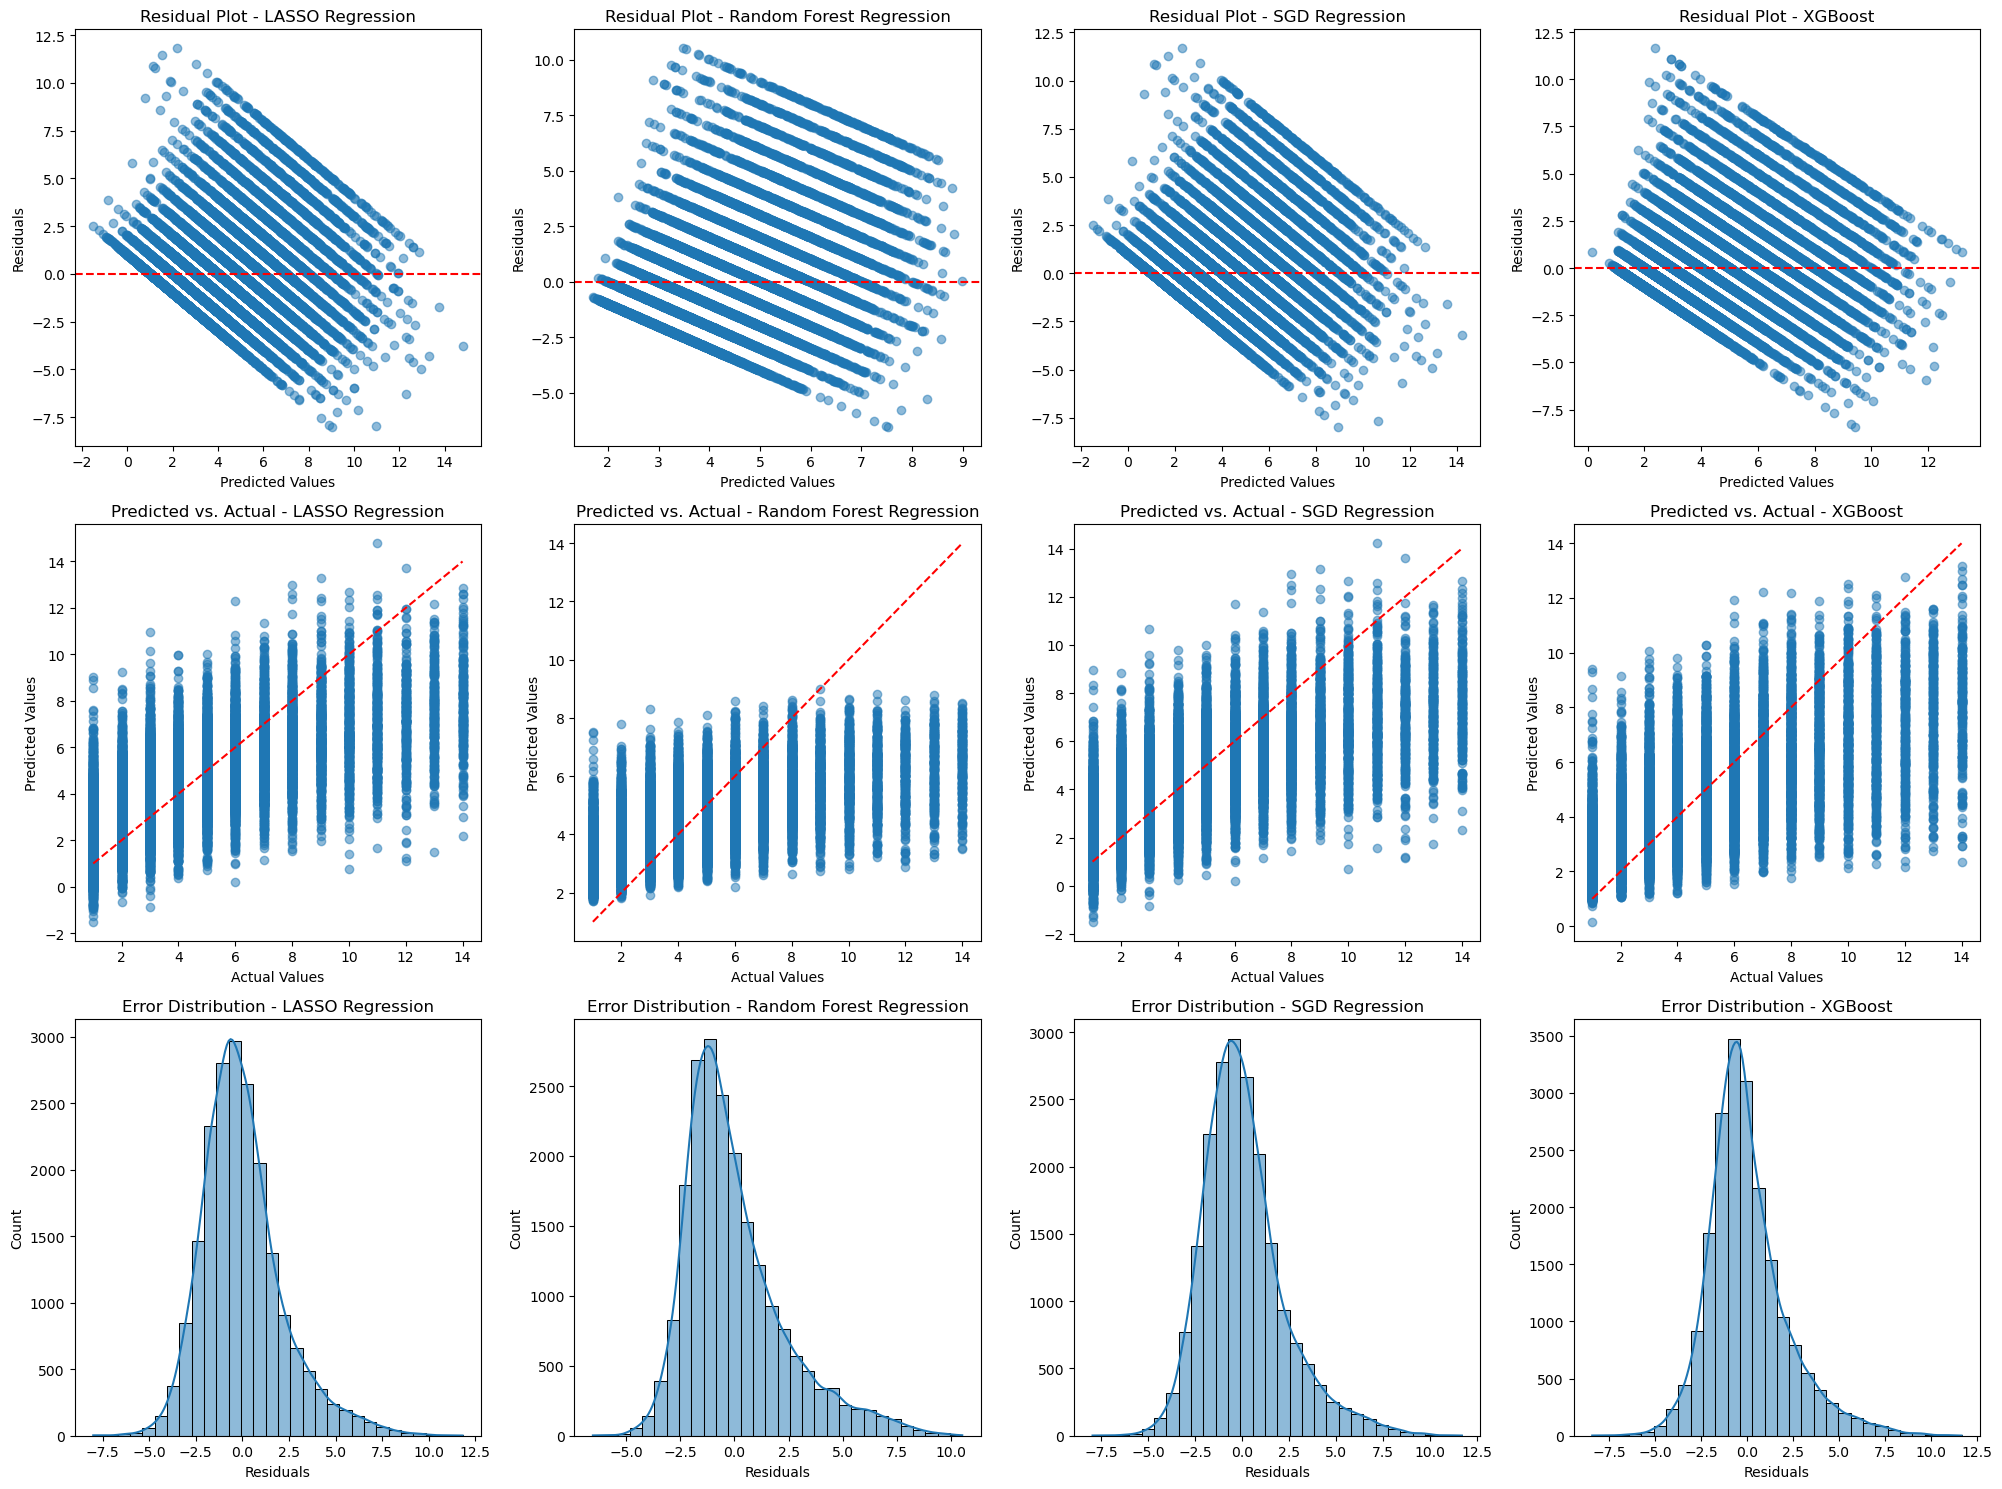

In [32]:
# Define regression models & labels
regressors = [lasso_pipeline, rf_model, sgd_pipeline, xgb_model]
reg_labels = ['LASSO Regression', 'Random Forest Regression', 'SGD Regression', 'XGBoost']

# Create subplots (3 rows: Residuals, Predicted vs Actual, Error Distribution)
fig, axes = plt.subplots(3, len(regressors), figsize=(len(regressors) * 5, 15))

for i, (model, label) in enumerate(zip(regressors, reg_labels)):
    
    # Predictions
    y_test_pred = model.predict(X_test_selected)
    residuals = y_test - y_test_pred  # Compute residuals (errors)

    # ---- Residual Plot ----
    axes[0, i].scatter(y_test_pred, residuals, alpha=0.5)
    axes[0, i].axhline(y=0, color="r", linestyle="--")  # Reference line at 0
    axes[0, i].set_title(f"Residual Plot - {label}")
    axes[0, i].set_xlabel("Predicted Values")
    axes[0, i].set_ylabel("Residuals")

    # ---- Predicted vs. Actual ----
    axes[1, i].scatter(y_test, y_test_pred, alpha=0.5)
    axes[1, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
    axes[1, i].set_title(f"Predicted vs. Actual - {label}")
    axes[1, i].set_xlabel("Actual Values")
    axes[1, i].set_ylabel("Predicted Values")

    # ---- Error Distribution ----
    sns.histplot(residuals, bins=30, kde=True, ax=axes[2, i])
    axes[2, i].set_title(f"Error Distribution - {label}")
    axes[2, i].set_xlabel("Residuals")

plt.tight_layout()
plt.show()



- The residual plots for all models show a pattern rather than random scatter, suggesting that the models are not fully capturing the underlying structure in the data.
- The error distributions are approximately normal.


#### Statistical Comparison of Models from the Residuals

In [36]:
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# Compute residuals for each model
lasso_residuals = np.abs(y_test - y_test_pred_lasso)
rf_residuals = np.abs(y_test - y_test_pred_rf)
sgd_residuals = np.abs(y_test - y_test_pred_sgd)
xgb_residuals = np.abs(y_test - y_test_pred_xgb)

# Store in dictionary
residuals_dict = {
    "LASSO Regression": lasso_residuals,
    "Random Forest Regression": rf_residuals,
    "SGD Regression": sgd_residuals,
    "XGBoost": xgb_residuals
}

# Combine all residuals into a single array
all_residuals = np.concatenate([residuals_dict[name] for name in model_names])

# Create labels for each model (repeated for each test sample)
model_labels = []
for name in model_names:
    model_labels.extend([name] * len(residuals_dict[name]))

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_residuals, model_labels, alpha=0.05)

# Print results
print("\nTukey's HSD Test Results (using holdout residuals):")
print(tukey_results)



Tukey's HSD Test Results (using holdout residuals):
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
        LASSO Regression Random Forest Regression   0.1154    0.0   0.078  0.1529   True
        LASSO Regression           SGD Regression    0.001 0.9999 -0.0365  0.0384  False
        LASSO Regression                  XGBoost  -0.0579 0.0004 -0.0954 -0.0205   True
Random Forest Regression           SGD Regression  -0.1145    0.0 -0.1519  -0.077   True
Random Forest Regression                  XGBoost  -0.1734    0.0 -0.2108 -0.1359   True
          SGD Regression                  XGBoost  -0.0589 0.0003 -0.0964 -0.0215   True
----------------------------------------------------------------------------------------



- Tukey’s HSD test found significant differences in residuals across most model pairs.
- The only non-significant difference was between LASSO and SGD Regression, suggesting they perform similarly in terms of error distribution.


#### Plot Learning Curves

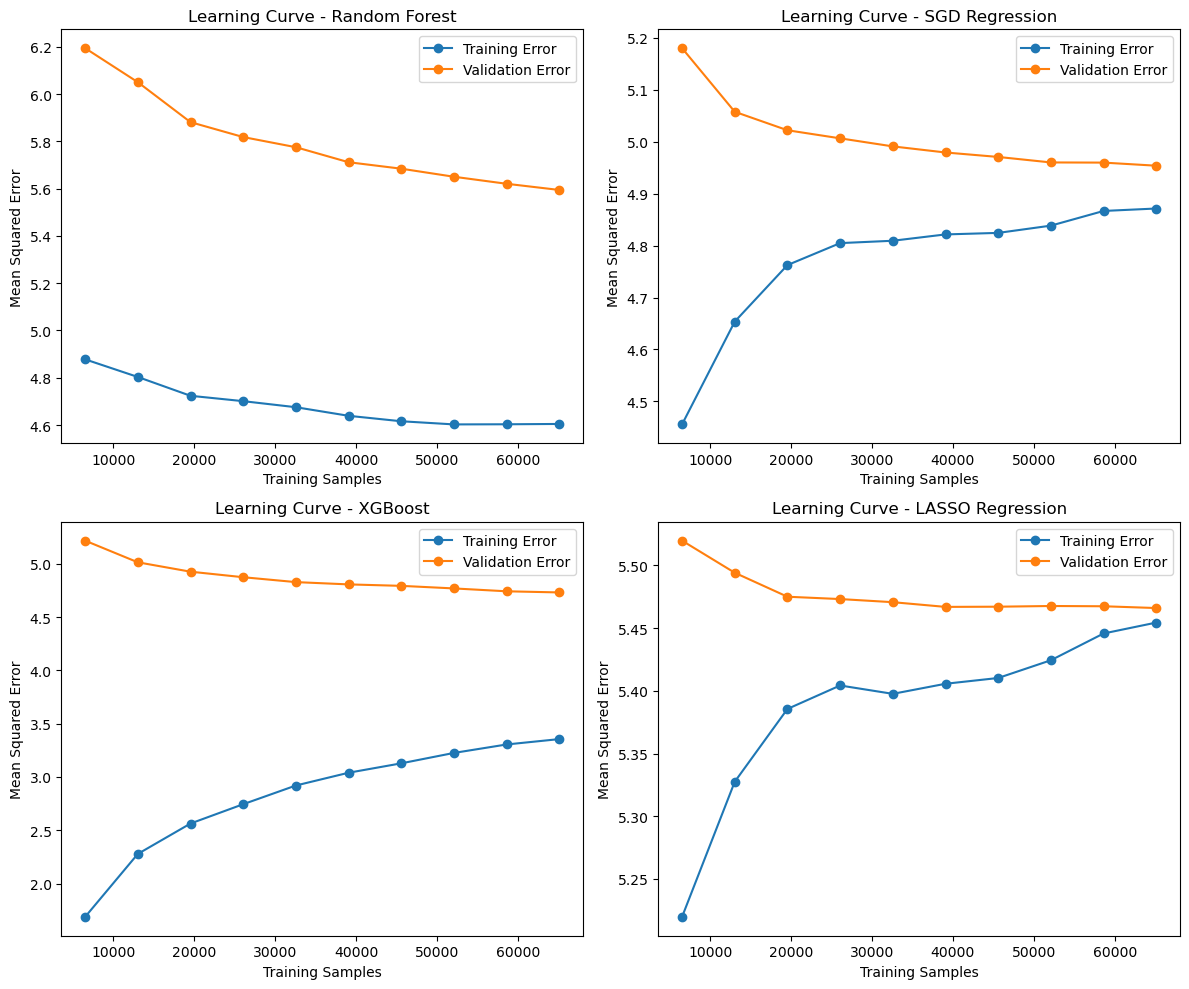

In [33]:
from sklearn.model_selection import learning_curve

# Apply fixes: Increase iterations, ensure scaling, and adjust alpha
lasso_pipeline.set_params(reg__max_iter=5000, reg__alpha=0.01)

# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Convert scores to positive MSE
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Error")
    plt.xlabel("Training Samples")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend(loc="best")

# Plot for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = {
    "LASSO Regression": lasso_pipeline,
    "Random Forest": rf_model,
    "SGD Regression": sgd_pipeline,
    "XGBoost": xgb_model
}

for ax, (name, model) in zip(axes.ravel(), models.items()):
    plot_learning_curve(model, X_train_selected, y_train, f"Learning Curve - {name}")
    plt.sca(ax)

plt.tight_layout()
plt.show()


Each learning curve shows Mean Squared Error (MSE) on both the training set and validation set as the number of training samples increases.

- Random Forest:  
  - Training error remains consistently low, while validation error gradually decreases but does not converge.
  - Large separation between training and validation curves suggest overfitting.
- SGD Regression:  
  - Training error starts low but increases as more data is used, converging towards validation error.  
  - Suggests high bias, meaning the model may be underfitting.
- XGBoost:  
  - Training error starts very low and increases slightly, while validation error decreases and stabilizes.  
  - Shows some evidence of overfitting but less than Random Forest.
- LASSO Regression:  
  - Training and validation errors are relatively close, with both stabilizing early.  
  - Suggests the model may be underfitting.


#### Interpreting the Lasso Model

In [34]:
# Extract the trained LASSO model from the pipeline
lasso_model = lasso_pipeline.named_steps['reg']

# Get feature names from the preprocessor (if applicable)
if 'preprocessor' in lasso_pipeline.named_steps:
    feature_names = list(X_train_selected.columns)  # If no preprocessing was applied
else:
    feature_names = list(X_train_selected.columns)  # Use raw feature names

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# Remove zero coefficients
lasso_nonzero = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]

# Count number of selected features
num_nonzero_features = lasso_nonzero.shape[0]

# Get top 20 important features (sorted by absolute coefficient value)
top_20_features = lasso_nonzero.assign(AbsCoefficient=lasso_nonzero['Coefficient'].abs()) \
                               .sort_values(by='AbsCoefficient', ascending=False) \
                               .drop(columns=['AbsCoefficient']) \
                               .head(20)

# Print results
print(f"\nTotal Number of Non-Zero Coefficients: {num_nonzero_features}")
print("\nTop 20 Most Important Features in LASSO:")
print(top_20_features)



Total Number of Non-Zero Coefficients: 924

Top 20 Most Important Features in LASSO:
                                       Feature  Coefficient
641                                 diag_1_731     4.803175
528                                 diag_1_583     3.958205
833                                 diag_1_V57     3.850634
126   medical_specialty_Pediatrics_Pulmonology     3.683990
286                                 diag_1_295     3.349534
287                                 diag_1_296     2.785223
186                                 diag_1_161     2.760550
304                                 diag_1_312     2.756563
221                                 diag_1_208     2.616360
830                                 diag_1_V54     2.425186
2297                                diag_3_V53     2.379746
281                                 diag_1_290     2.319377
977                                 diag_2_312     2.298668
298                                 diag_1_307     2.281423
285           

## Deployment

#### Medication Change Classification Model

Use Case: 
- This model can help insurance companies or pharmacies predict which patients are likely to have a medication change.  
- It can be used to allocate resources efficiently, reduce costs, and identify potential prescribing errors.

Measuring the Model’s Value:
 - Monitor operational efficiency: Streamline resource allocation.

Deployment Strategy:
- Processing: Decide if predictions are batch processed (e.g. daily, weekly) or in real-time based on patient updates.
- Environment: What is the architecture of the client's environment and what integrations would be necessary?

Data Collection & Model Updates:
- Quarterly or Yearly Reassessment: Re-evaluate performance using new patient data.
- Feature Drift Analysis: Are some variables becoming less predictive over time?
- New Data Sources: Could lab results or patient adherence behavior improve the model?

#### Time in Hospital Regression Model

Use Case: 
- Hospitals and insurance providers can use this model to predict patient length of stay, helping improve bed management, resource allocation, and cost forecasting.

Measuring the Model’s Value:
- Hospital Efficiency: Optimize bed availability and staffing.
- Cost Reduction: Identify high-risk patients earlier to reduce excessive hospital stays.
- Improved Patient Care: More accurate discharge planning leads to better patient outcomes.

Deployment Strategy:
- Insurance Claim Preprocessing: Use predictions for cost estimation.
- Hospital Resource Planning: Forecast future occupancy and adjust staffing levels
- Environment: What is the architecture of the client's environment and what integrations would be necessary?

Data Collection & Model Updates:
- Monitor Model Drift: Are patient demographics or treatments changing?  
- New Data: Consider adding seasonal data to improve predictions.
- Regular Recalibration: Re-train the model annually using the latest hospital data.


## Appendix: Free-Reign Modeling

In [37]:
df = df.copy()

#### Data Cleaning:
Initial data cleaning includes handling NAs, identifying high cardinality columns for frequency encoding, one-hot encoding categorical columns, and dropping any other columns thatr may not contribute to the analysis

In [38]:
# Replace '?' with NaN 
df.replace('?', pd.NA, inplace=True)

# Check for columns with missing values
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])  # Columns with missing data



# Drop columns that may not contribute to analysis
df.drop(['encounter_id', 'patient_nbr','weight','max_glu_serum','A1Cresult','examide','citoglipton'], axis=1, inplace=True)


high_cardinality_columns = [col for col in df.columns if df[col].nunique() > 9]

# Step 1: Create frequency maps for all columns
frequency_maps = {col: df[col].value_counts() for col in high_cardinality_columns}

# Step 2: Apply frequency encoding
for col in high_cardinality_columns:
    df[f'{col}_encoded'] = df[col].map(frequency_maps[col])

# Apply encoding with fallback for unseen categories
for col in high_cardinality_columns:
    df[f'{col}_encoded'] = df[col].map(frequency_maps[col]).fillna(0)


# Dropping old high cardinality columns
df.drop(high_cardinality_columns, axis=1, inplace=True)

# Identify all new columns that have 'encoded' in their names
high_cardinality_columns = [col for col in df.columns if 'encoded' in col ]
"""or 'change' in col"""

categorical_columns = df.select_dtypes(include='object').columns
categorical_columns = list(categorical_columns[0:23]) + list(categorical_columns[24:26])
print(categorical_columns)


#one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df.drop(columns=high_cardinality_columns + ['change']), 
                            columns=categorical_columns, 
                            drop_first=False)

df_encoded = pd.concat([df[high_cardinality_columns] , df[['change']], df_encoded], axis=1)


race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64
['race', 'gender', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', 'readmitted']


#### Further cleaning involves factorizing all categorical variables and removing features with a value frequency over 80%

I chose to remove any column with one value that dominates the field by more than 80% to get rid of noise and boost model efficiency

In [39]:
## Remove duplicate columns
df_encoded = df_encoded.loc[:, ~df_encoded.T.duplicated()]

# Check for columns with missing values
missing_summary = df_encoded.isnull().sum()
print(missing_summary[missing_summary > 0])  # Columns with missing data
df_encoded = df_encoded.drop(columns=['payer_code_encoded'] + ['medical_specialty_encoded'])

# Factorize all categorical variables

# Select all boolean columns
categorical_columns = list(df_encoded.select_dtypes(include='bool').columns)

# Append 'readmitted' column to the list (if it exists in the DataFrame)
if 'change' in df_encoded.columns:
    categorical_columns.append('change')

# Factorize    
for col in categorical_columns:
    df_encoded[col], mapping = pd.factorize(df_encoded[col])

# print(df_encoded.info())  
# print(df_encoded.head())  
print(df_encoded['change'])

columns_and_dtypes_df = df_encoded.dtypes.reset_index()
columns_and_dtypes_df.columns = ['Column', 'Data Type']
print(columns_and_dtypes_df)
"""
Left_out = df[['readmitted','Change']]

# Factorize    
for col in Left_out:
    df_encoded[col], mapping = pd.factorize(df_encoded[col])

"""
# Define threshold
threshold = 0.8

# Compute the most common value frequency per column
highly_constant_columns = [
    col for col in df_encoded.columns 
    if df_encoded[col].value_counts(normalize=True).iloc[0] > threshold
]

# Drop these columns
df_filtered = df_encoded.drop(columns=highly_constant_columns)

# Print removed columns for reference
print("Dropped columns:", highly_constant_columns)

# Display the cleaned dataset
print(df_filtered.shape)


Series([], dtype: int64)
0         0
1         1
2         0
3         1
4         1
         ..
101761    1
101762    0
101763    1
101764    1
101765    0
Name: change, Length: 101766, dtype: int64
                              Column Data Type
0                        age_encoded     int64
1   discharge_disposition_id_encoded     int64
2        admission_source_id_encoded     int64
3           time_in_hospital_encoded     int64
4         num_lab_procedures_encoded     int64
..                               ...       ...
93                    diabetesMed_No     int64
94                   diabetesMed_Yes     int64
95                    readmitted_<30     int64
96                    readmitted_>30     int64
97                     readmitted_NO     int64

[98 rows x 2 columns]
Dropped columns: ['number_outpatient_encoded', 'number_emergency_encoded', 'race_AfricanAmerican', 'race_Asian', 'race_Hispanic', 'race_Other', 'gender_Unknown/Invalid', 'metformin_Down', 'metformin_No', 'metformi

#### Next, we will use a random forest model to determine feature importance and further reduce the features of our data and define our reduced dataset to be used for model building

In [41]:
from sklearn.ensemble import RandomForestClassifier
# Quick feature importance analysis
X = df_filtered.drop(['change'], axis=1)
y = df_filtered['change']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

for feature,importance in feature_importance.items():
     if importance >= .02:
         print(f"{feature}: {importance}")
         
# Save feature names with importance >= 0.02 into a list
important_features = feature_importance[feature_importance >= 0.02].index.tolist()

# Now, `important_features` contains the feature names
print(important_features)

'''
sns.pairplot(df_encoded, vars= important_features, hue='readmitted')
plt.show()
'''
df_reduced = df_filtered[important_features].copy()

df_reduced.loc[:, 'change'] = df_filtered['change']

insulin_No: 0.16046023452653593
insulin_Steady: 0.10500799819552975
diabetesMed_Yes: 0.09611544597905328
diabetesMed_No: 0.09059137219899344
num_lab_procedures_encoded: 0.06511451195921641
num_medications_encoded: 0.060344793813028035
diag_2_encoded: 0.05974984589679944
diag_1_encoded: 0.05973121256117793
diag_3_encoded: 0.05809980873153814
time_in_hospital_encoded: 0.03701168689693641
age_encoded: 0.03474990210108076
number_diagnoses_encoded: 0.02618142970516673
num_procedures: 0.025441949470551433
discharge_disposition_id_encoded: 0.022949599315295326
['insulin_No', 'insulin_Steady', 'diabetesMed_Yes', 'diabetesMed_No', 'num_lab_procedures_encoded', 'num_medications_encoded', 'diag_2_encoded', 'diag_1_encoded', 'diag_3_encoded', 'time_in_hospital_encoded', 'age_encoded', 'number_diagnoses_encoded', 'num_procedures', 'discharge_disposition_id_encoded']


### Model Building

#### Importing Packages:

In [42]:
# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image

# pipelines
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# individual classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# ensemble classifiers
##(not that we use a user defined class for MajorityVoting)
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

# others
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone

#### Defining Classes

In [43]:

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out
        

#### Splitting Data

In [44]:
df_reduced.fillna(0, inplace=True)  # Replace NaNs with 0

# create X and y arrays
X = np.array(df_reduced.iloc[:, 1:])
y = np.array(df_reduced.iloc[:, 0])


# create samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1, stratify=y)

#### Training Decision Tree and KNN classifiers

In [45]:
clf1 = DecisionTreeClassifier(max_depth=2,
                              criterion='entropy')

clf2 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

# the KNN classifier is not scale-invariant whereas the decission tree classifier is.
# remember it's a good habit to work with standardized features, so let's use a Pipeline (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to standardize the features for KNN
# the StandardScaller method in sklearn.preprocessing module does this for us
clf2_pipeline = Pipeline([['sc', StandardScaler()],
                  ['clf', clf2]])

# define classifier labels
clf_names = ['Decision tree', 'KNN']

# evaluate the model performance for each classifier using 10-fold cross validation on the training data
# note that with the 10-fold validation we don't try to find the optimal combination of hyperparameter values (i.e., use the GridSearchCV() method from sklearn.model_selection module)
# instead, we want to fine-tune the performance given a single set of hyperparameter values
print('10-fold cross validation (CV):\n')
for clf, name in zip([clf1, clf2_pipeline], clf_names):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1) # n_jobs = the number of CPUs to use, set to -1 to use all
    print("CV accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name)) # cross_val_score() returns stats(e.g., mean and variance) for accuracy scores
    

10-fold cross validation (CV):

CV accuracy: 0.91 (+/- 0.00) [Decision tree]
CV accuracy: 0.91 (+/- 0.00) [KNN]


This shows the the accuracy of both classifiers is the same

#### Combining Classifiers for Majority Rule Voting and evaluating using 10-fold cv

In [46]:
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2_pipeline])

clf_names += ['Majority voting']
all_clf = [clf1, clf2_pipeline, mv_clf]

for clf, label in zip(all_clf, clf_names):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1)
    print("CV accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))
    

CV accuracy: 0.91 (+/- 0.00) [Decision tree]
CV accuracy: 0.91 (+/- 0.00) [KNN]
CV accuracy: 0.91 (+/- 0.00) [Majority voting]


The majority vote classifier didnt improve the accuracy over the KNN or decision tree

#### Ensemble Learning and Bagging

In [47]:
# ENSEMBLE LEARNING - BAGGING

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None)

bag = BaggingClassifier(tree,
                        n_estimators=500,
                        n_jobs=1)

# performance of the base tree alone
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

# performance of bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.888
Bagging train/test accuracies 1.000/0.921


Here, the unpruned decision tree predicst all rtraining class labels correctly, but the generalization does not perform as well as the past models.
The bagging accuracy here excels though, most likely due to the multiple instances of the same model being trained.

#### ENSEMBLE LEARNING - ADABOOST

In [48]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1)

ada = AdaBoostClassifier(tree,
                         n_estimators=500)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)


ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.769/0.767
AdaBoost train/test accuracies 0.915/0.915


Here, the AdaBoost does imporove the test accuracy a little but not as much as the bagged decision tree model

### Plotting Model Comparisons

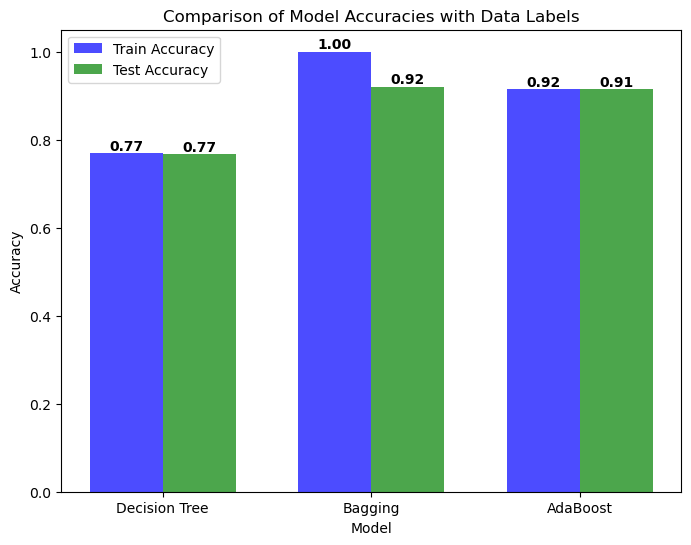

In [49]:
# Define model names
models = ['Decision Tree', 'Bagging', 'AdaBoost']

# Define training and testing accuracies (Replace these values with actual results)
train_accuracies = [tree_train, bag_train, ada_train]  # Example values
test_accuracies = [tree_test, bag_test, ada_test]

# Set bar positions
x = np.arange(len(models))  # Index positions for models
width = 0.35  # Bar width

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars for train and test accuracy
bars_train = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='blue', alpha=0.7)
bars_test = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='green', alpha=0.7)

# Add data labels on top of the bars
for bar in bars_train:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

for bar in bars_test:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies with Data Labels')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

### More Classification

In [52]:
raw_url = 'https://raw.githubusercontent.com/kdhenderson/ML7331_team_project/main/data/diabetes%2B130-us%2Bhospitals%2Bfor%2Byears%2B1999-2008/diabetic_data.csv'

df = pd.read_csv(raw_url)

In [53]:
# Replace `?` with NaN for now
df_clean = df.copy()
df_clean.replace('?', np.nan, inplace=True)

# Replace NaN ('?') with 'Unknown' in the specified columns
columns_to_update_1 = ['medical_specialty', 'payer_code', 'race']
df_clean[columns_to_update_1] = df_clean[columns_to_update_1].replace(np.nan, 'Unknown')

# Replace NaN ('?') with 'Unknown' in the specified columns
columns_to_update_2 = ['diag_1', 'diag_2', 'diag_3']
df_clean[columns_to_update_2] = df_clean[columns_to_update_2].replace(np.nan, 'Unknown/None')

# Replace NaN with 'Untested' in the specified columns
columns_to_update_3 = ['max_glu_serum', 'A1Cresult']
df_clean[columns_to_update_3] = df_clean[columns_to_update_3].replace(np.nan, 'Untested')

# Convert categorical variables `patient_nbr`, `admission_type_id`, `discharge_disposition_id`, `admission_source_id`
# from integer to object datatype.
categoricalInt_cols = ['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[categoricalInt_cols] = df_clean[categoricalInt_cols].astype('category')
df_clean[['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']].dtypes

# Remove encounter id, examide, citoglipton, weight, and patient_nbr from the dataset.
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

In [54]:
# # Define the correct order for each variable
readmit_order = ['<30', '>30', 'NO']
drug_order = ['No', 'Down', 'Steady', 'Up']
max_glu_serum_order = ['Untested', 'Norm', '>200', '>300']
a1cresult_order = ['Untested', 'Norm', '>7', '>8']
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

# # List of drug-related variables
drug_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide',
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol',
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']

# # Reorder categories in the DataFrame
df_clean['readmitted'] = pd.Categorical(df_clean['readmitted'], categories=readmit_order, ordered=True)
df_clean['max_glu_serum'] = pd.Categorical(df_clean['max_glu_serum'], categories=max_glu_serum_order, ordered=True)
df_clean['A1Cresult'] = pd.Categorical(df_clean['A1Cresult'], categories=a1cresult_order, ordered=True)
df_clean['age'] = pd.Categorical(df_clean['age'], categories=age_order, ordered=True)

for col in drug_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

In [55]:
# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

In [56]:
print( df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  category
 4   discharge_disposition_id  101766 non-null  category
 5   admission_source_id       101766 non-null  category
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

### Check Response Variable

In [57]:
print(df_clean['change'].describe())

count     101766
unique         2
top           No
freq       54755
Name: change, dtype: object


In [58]:
# Find the proportion of each response class.
print(df_clean['change'].value_counts()/df_clean['change'].count())

change
No    0.538048
Ch    0.461952
Name: count, dtype: float64


### Classification: Change
#### From the perspective of an insurance company, it may prove valuable if we could predict whether a patient would have change in their prescribed medication based on some known attributes.

In [59]:
numeric_df = df_clean.select_dtypes(include=[np.number])
numeric_df

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1,41,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9
2,2,11,5,13,2,0,1,6
3,2,44,1,16,0,0,0,7
4,1,51,0,8,0,0,0,5
...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9
101762,5,33,3,18,0,0,1,9
101763,1,53,0,9,1,0,0,13
101764,10,45,2,21,0,0,1,9


In [60]:
# Summary Statistics
description = numeric_df.describe()
mode = numeric_df.mode(numeric_only = True).iloc[0]
variances = numeric_df.var(numeric_only = True)
ranges = numeric_df.max(numeric_only = True) - numeric_df.min(numeric_only = True)
kurt = numeric_df.kurt(numeric_only = True)
skew = numeric_df.skew(numeric_only = True)

summary_df = pd.DataFrame({
    'Count': description.loc['count'],
    'Mean': description.loc['mean'],
    'Std': description.loc['std'],
    'Variance': variances,
    'Min': description.loc['min'],
    '25%': description.loc['25%'],
    'Median': description.loc['50%'],
    '75%': description.loc['75%'],
    'Max': description.loc['max'],
    'Mode': mode,
    'Range': ranges,
    'Kurtosis': kurt,
    'Skew': skew
})

numeric_summary_df = summary_df[['Count', 'Mean', 'Std', 'Variance', 'Min', '25%', 'Median', '75%', 'Max', 'Mode', 'Range', 'Kurtosis', 'Skew']]
numeric_summary_df.reset_index(inplace = True)
numeric_summary_df.rename(columns={'index': 'Variable'}, inplace = True)

# Display the final DataFrame
numeric_summary_df

,Variable,Count,Mean,Std,Variance,Min,25%,Median,75%,Max,Mode,Range,Kurtosis,Skew
0,time_in_hospital,101766.0,4.395987,2.985108,8.910868,1.0,2.0,4.0,6.0,14.0,3,13,0.850251,1.133999
1,num_lab_procedures,101766.0,43.095641,19.674362,387.080530,1.0,31.0,44.0,57.0,132.0,1,131,-0.245074,-0.236544
2,num_procedures,101766.0,1.339730,1.705807,2.909777,0.0,0.0,1.0,2.0,6.0,0,6,0.857110,1.316415
3,num_medications,101766.0,16.021844,8.127566,66.057332,1.0,10.0,15.0,20.0,81.0,13,80,3.468155,1.326672
4,number_outpatient,101766.0,0.369357,1.267265,1.605961,0.0,0.0,0.0,0.0,42.0,0,42,147.907736,8.832959
5,number_emergency,101766.0,0.197836,0.930472,0.865779,0.0,0.0,0.0,0.0,76.0,0,76,1191.686726,22.855582
6,number_inpatient,101766.0,0.635566,1.262863,1.594824,0.0,0.0,0.0,1.0,21.0,0,21,20.719397,3.614139
7,number_diagnoses,101766.0,7.422607,1.933600,3.738810,1.0,6.0,8.0,9.0,16.0,9,15,-0.079056,-0.876746


In [61]:
def create_numeric_variable_grid(n_variables, n_cols=3, figsize=(16, 4)):
    """
    Creates a dynamic grid layout for subplots.

    Parameters:
    - n_variables: Total number of variables to visualize.
    - n_cols: Number of columns in the subplot grid.
    - figsize: Tuple representing the figure size per row.

    Returns:
    - fig, axes: Matplotlib figure and flattened axes array.
    """
    # Calculate the number of rows needed
    n_rows = (n_variables + n_cols - 1) // n_cols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten axes for easier iteration

    # Turn off unused subplots
    for ax in axes[n_variables:]:
        ax.axis("off")  # Hide unused axes

    return fig, axes

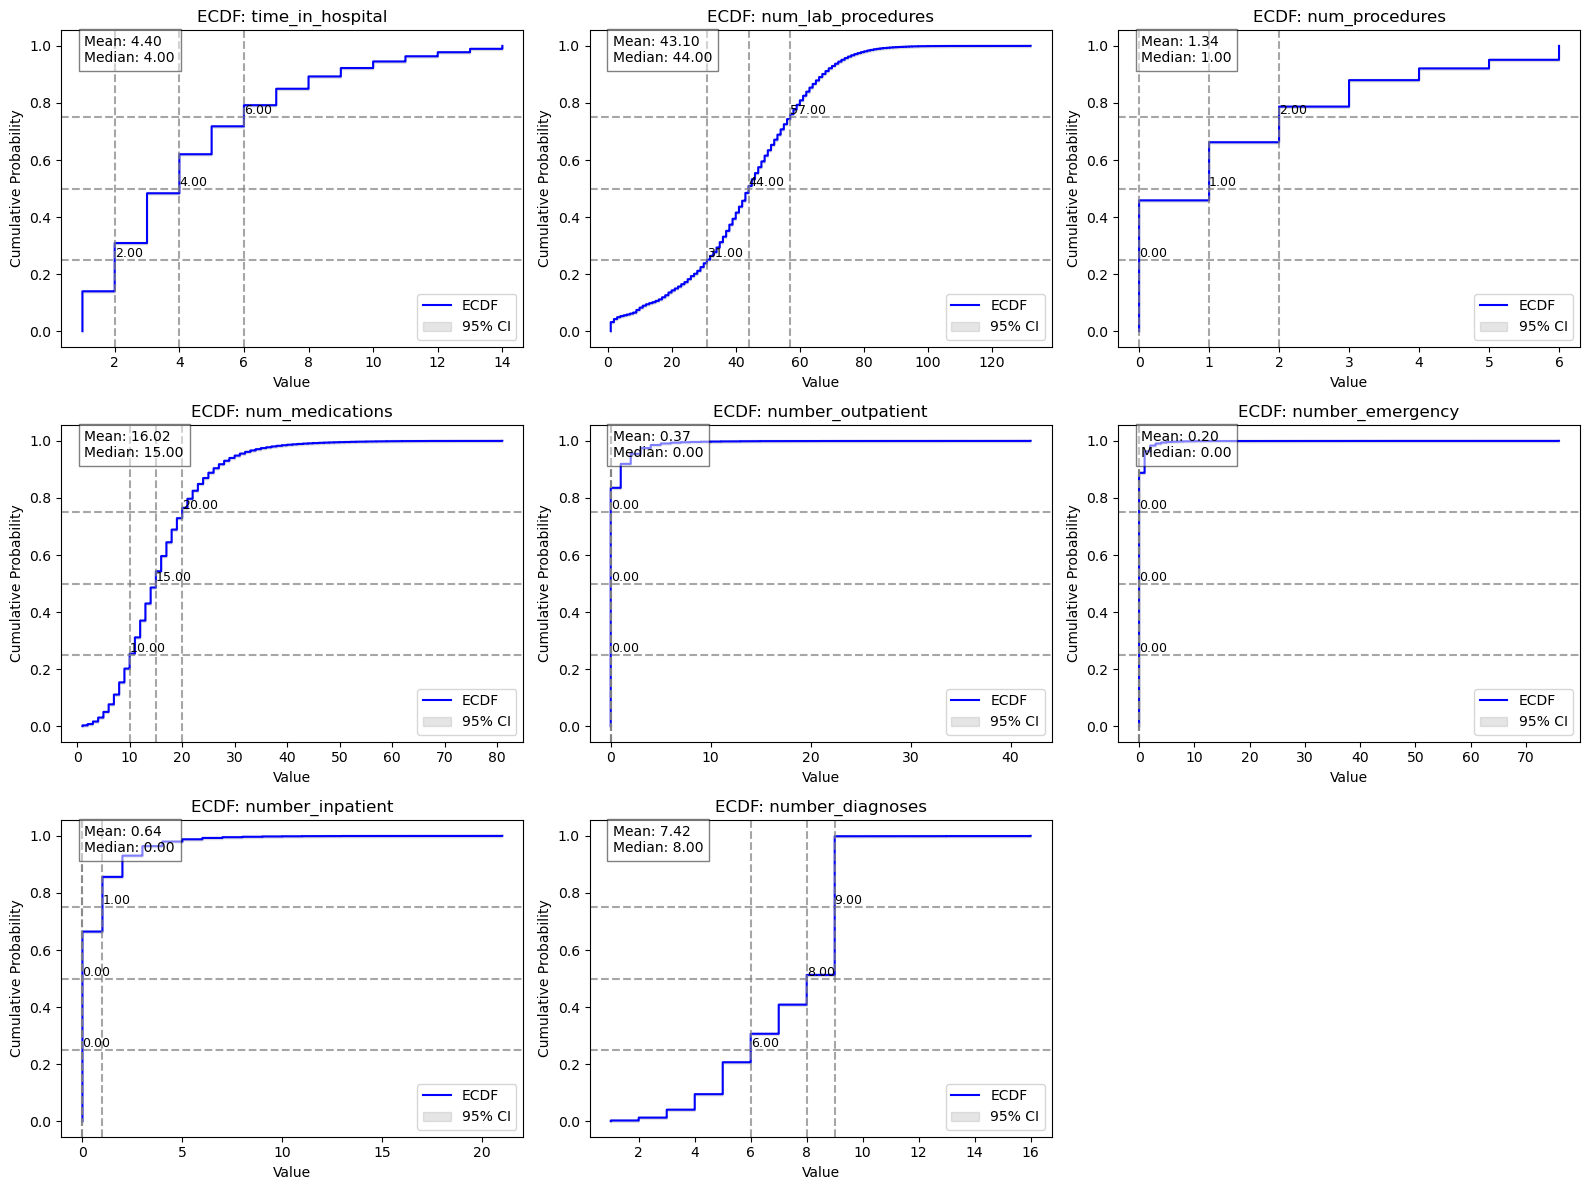

In [62]:
def ecdf(data, axes):
    """
    ECDF plot with percentile markers, confidence intervals, and summary metrics.
    """
    # Sort data and compute ECDF
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)

    # Plot ECDF
    axes.step(x, y, where="post", color="blue", label="ECDF")
    
    # Highlight percentiles
    percentiles = [0.25, 0.5, 0.75]
    percentile_values = np.percentile(data, [25, 50, 75])
    for p, value in zip(percentiles, percentile_values):
        axes.axhline(p, linestyle="--", color="gray", alpha=0.7)
        axes.axvline(value, linestyle="--", color="gray", alpha=0.7)
        axes.text(value, p, f"{value:.2f}", fontsize=9, verticalalignment="bottom")

    # Add confidence intervals
    n = len(data)
    ci_band = 1.36 / np.sqrt(n)  # Approximation for 95% CI
    axes.fill_between(x, y - ci_band, y + ci_band, color="gray", alpha=0.2, label="95% CI")

    # Annotate summary statistics
    mean, median = np.mean(data), np.median(data)
    axes.text(0.05, 0.9, f"Mean: {mean:.2f}\nMedian: {median:.2f}",
            transform=axes.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Add labels and title
    axes.set_title(f"ECDF: {column}", fontsize=12)
    axes.set_xlabel("Value", fontsize=10)
    axes.set_ylabel("Cumulative Probability", fontsize=10)
    axes.legend()

fig, axes = create_numeric_variable_grid(len(numeric_df.columns))
for i, column in enumerate(numeric_df.columns):
    ecdf(numeric_df[column].dropna(), axes[i])

plt.tight_layout()
plt.show()

In [63]:
vis_df = df_clean.select_dtypes(include=['object', 'category'])
vis_df = vis_df.drop(['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'admission_type_id', 'max_glu_serum', 'A1Cresult'], axis=1)

vis_df.columns

Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'payer_code', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

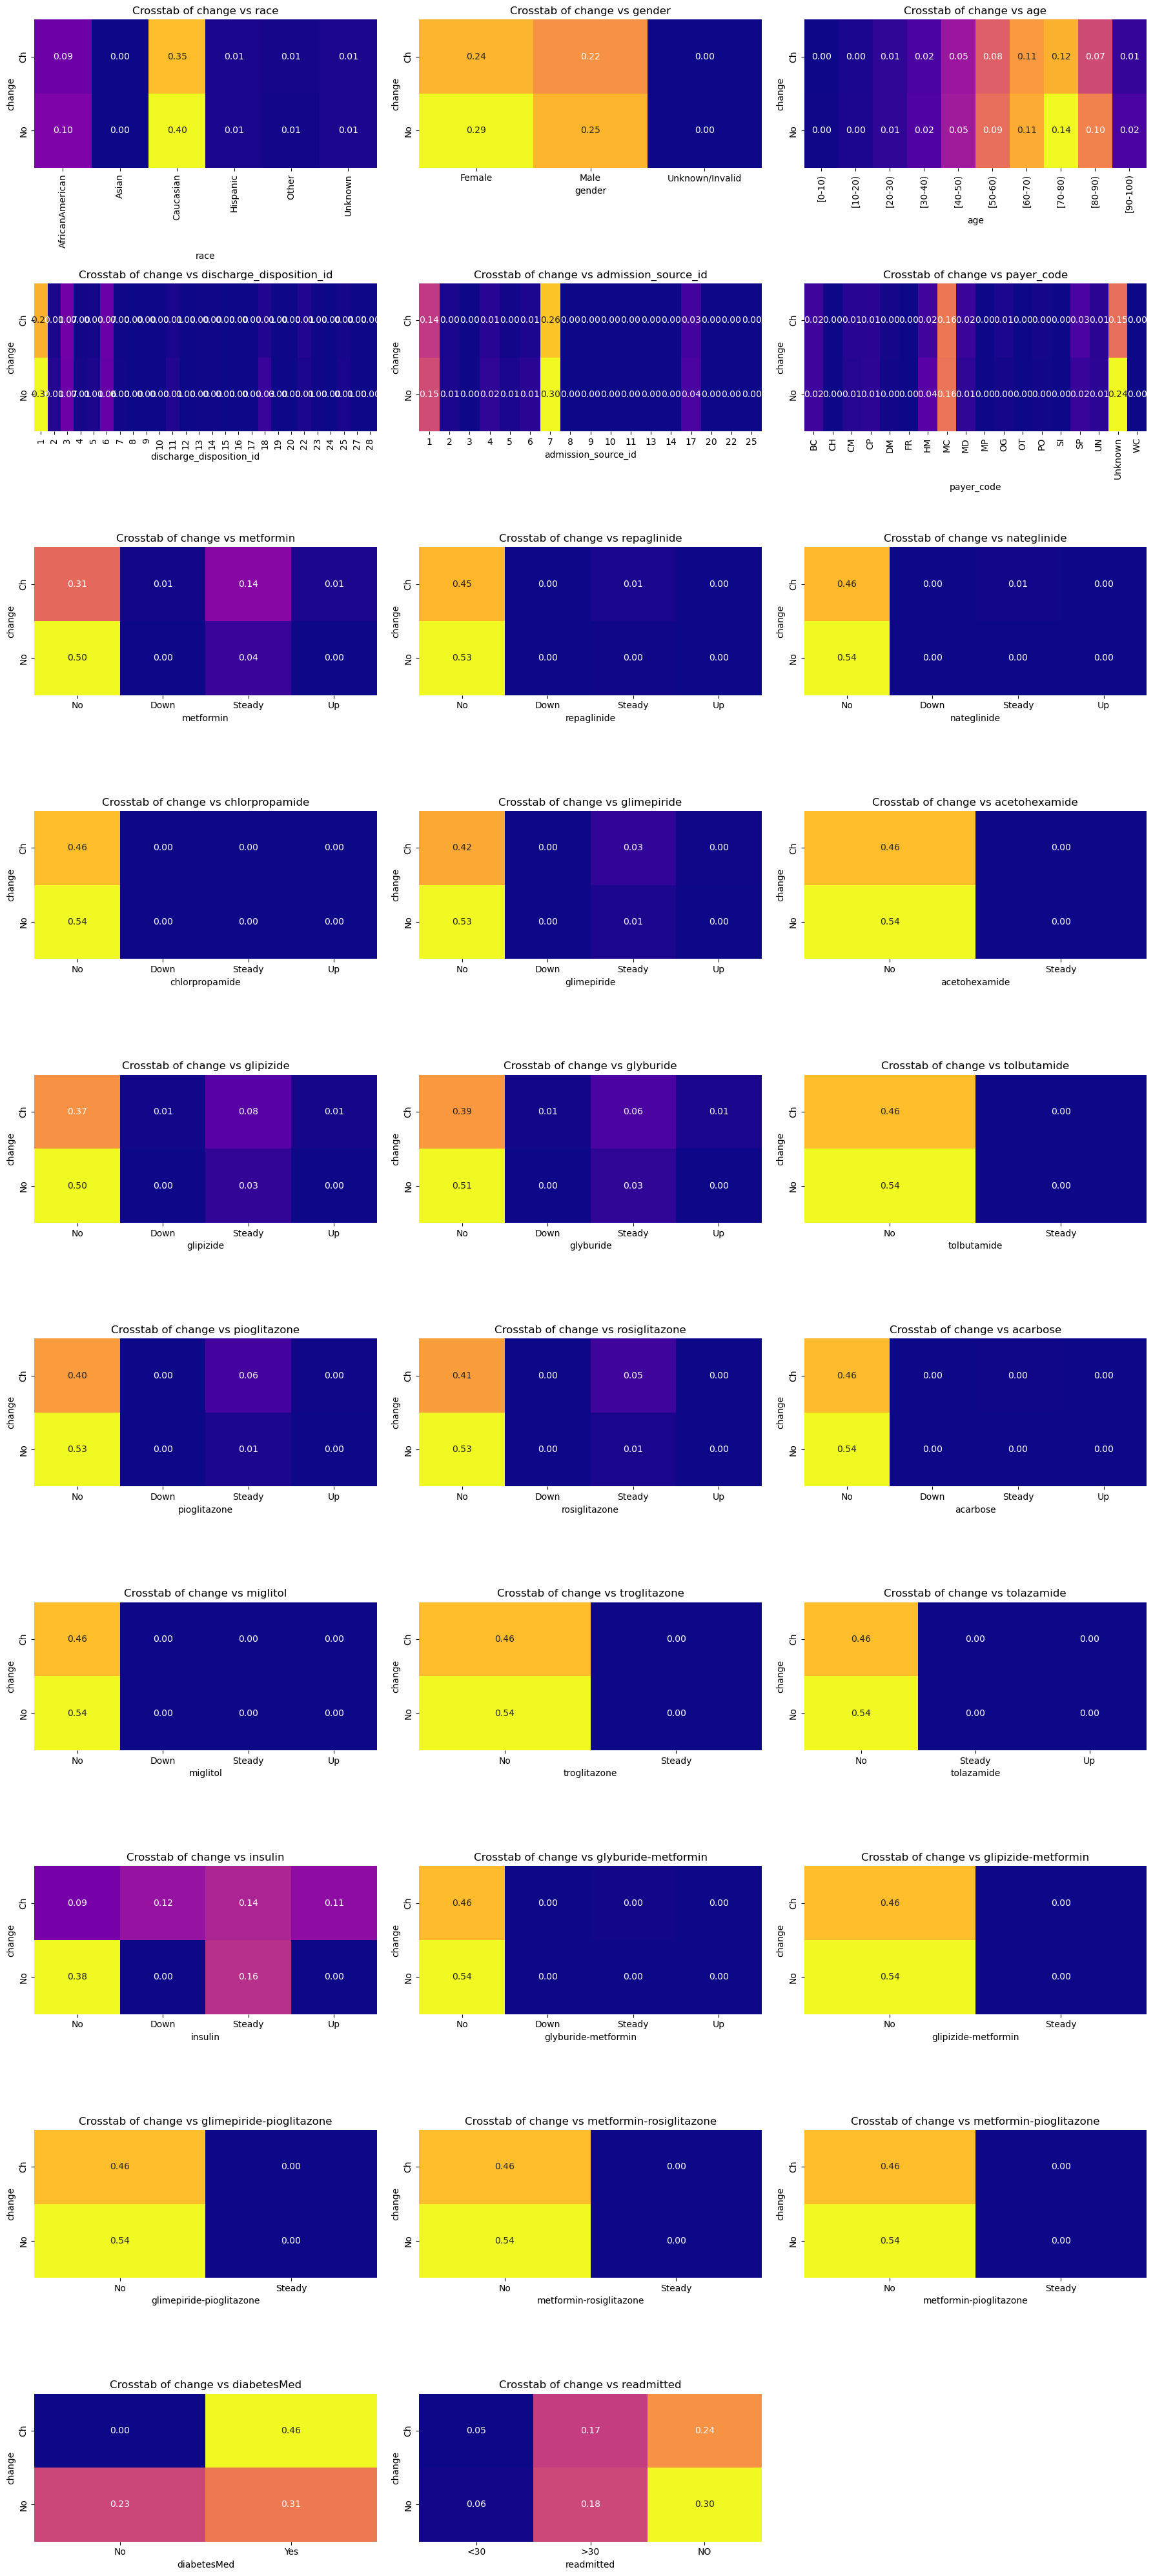

In [64]:
response = 'change'  # Attribute of interest
other_columns = [col for col in vis_df.columns if col != response]  # Exclude target

crosstab_results = {}
for column in other_columns:
    crosstab_results[column] = pd.crosstab(vis_df[response], vis_df[column])

def create_heatmaps(crosstab_results, response, normalization='none', n_cols=4, cmap="plasma"):
    """
    Creates a grid of heatmaps for given crosstab results.

    Parameters:
        crosstab_results (dict): Dictionary of crosstabs for each feature.
        response (str): Name of the response variable.
        normalization (str): Normalization type ('row', 'column', 'overall').
        n_cols (int): Number of columns in the subplot grid.
        cmap (str): Colormap for the heatmaps.
    """
    n_features = len(crosstab_results)  # Total features to plot
    n_rows = -(-n_features // n_cols)  # Compute rows by rounding up

    # Create the figure and axes for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=False, sharey=False)
    axes = np.ravel(axes)  # Flatten axes for consistent 1D handling

    # Loop through crosstabs and create heatmaps
    for i, (col, crosstab) in enumerate(crosstab_results.items()):
        
        # Normalize the crosstab based on the selected normalization
        if normalization == 'none':
            normalized_crosstab = crosstab 
        elif normalization == 'row':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)    # Normalize by row
        elif normalization == 'column':
            normalized_crosstab = crosstab.div(crosstab.sum(axis=0), axis=1)    # Normalize by column
        elif normalization == 'overall':
            normalized_crosstab = crosstab / crosstab.values.sum()              # Normalize overall
        else:
            raise ValueError("Invalid normalization type. Choose 'none', row', 'column', or 'overall'.")

        # Plot heatmap
        sns.heatmap(normalized_crosstab, annot=True, fmt=".2f" if normalization != 'none' else "d", cmap=cmap, cbar=False, ax=axes[i])
        
        axes[i].set_title(f"Crosstab of {response} vs {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(response)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# create_heatmaps(crosstab_results, response=response, normalization='none', n_cols=4, cmap="plasma")       #   Crosstab Heatmap: No Normalization, Raw Counts
# create_heatmaps(crosstab_results, response=response, normalization='row', n_cols=4, cmap="plasma")        #   Crosstab Heatmap: No Normalization, Proportion of Factor Levels within the Response Variable
# create_heatmaps(crosstab_results, response=response, normalization='column', n_cols=4, cmap="plasma")     #   Crosstab Heatmap: Column Normalization, Proportion of Factor Levels within the Predictor Variable
create_heatmaps(crosstab_results, response=response, normalization='overall', n_cols=3, cmap="plasma")      #   Crosstab Heatmap: Overall Normalization, Proportion of Total Data

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#One Hot Encoding
df_encoded = df_clean.copy()

# Split data before encoding (Prevents Data Leakage)
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['change']),
                                                    df_encoded['change'],
                                                    test_size=0.2, stratify=df_encoded['change'], random_state=1234)

# Encode `change`
y_train = y_train.map({"No": 0, "Ch": 1})
y_test = y_test.map({"No": 0, "Ch": 1})


# Apply frequency encoding only on high-cardinality categorical variables
high_cardinality_cols = ['medical_specialty', 'payer_code', 'diag_1', 'diag_2', 'diag_3']
for col in high_cardinality_cols:
    if col in X_train.columns:
        freq_map = X_train[col].value_counts().to_dict()  # Train set only
        X_train[col] = X_train[col].map(freq_map)
        X_test[col] = X_test[col].map(freq_map).fillna(0)  # Fill unseen categories with 0

# Apply one-hot encoding to remaining categorical variables
categoric_columns = X_train.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categoric_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categoric_columns, drop_first=True)

# Convert boolean values to 0/1
X_train = X_train.astype(int)
X_test = X_test.astype(int)

In [66]:
# Standardize the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Identify numeric features
binary_features = [col for col in X_train.columns if set(X_train[col].unique()) == {0, 1}]
numeric_features = list(set(X_train.columns) - set(binary_features))

# Apply Scaling to numeric & frequency-encoded features

# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Binary Features:", binary_features)
print("Numeric + Frequency-Encoded Features:", numeric_features)

# Final check
print(X_train.head(), X_test.head())

Binary Features: ['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'race_Unknown', 'gender_Male', 'gender_Unknown/Invalid', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'admission_type_id_6', 'admission_type_id_7', 'admission_type_id_8', 'discharge_disposition_id_2', 'discharge_disposition_id_3', 'discharge_disposition_id_4', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'discharge_disposition_id_7', 'discharge_disposition_id_8', 'discharge_disposition_id_9', 'discharge_disposition_id_10', 'discharge_disposition_id_11', 'discharge_disposition_id_12', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_15', 'discharge_disposition_id_16', 'discharge_disposition_id_17', 'discharge_disposition_id_18', 'discharge_disposition_id_19', 'discharge_disp

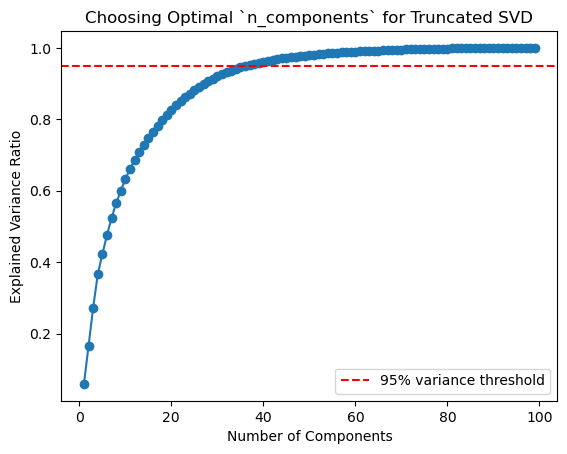

In [67]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Try different values of n_components
n_components_range = range(1, 100, 1)  # From 1 to 100, step 1
explained_variance = []

for n in n_components_range:
    svd = TruncatedSVD(n_components=n, random_state=1234)
    svd.fit(X_train)
    explained_variance.append(sum(svd.explained_variance_ratio_))

# Plot variance explained
plt.plot(n_components_range, explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance threshold")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Choosing Optimal `n_components` for Truncated SVD")
plt.legend()
plt.show()

In [69]:
from sklearn.decomposition import TruncatedSVD

# Define the number of components (From the previous graph, we can see that 37 is the threshold value to achieve 95% variance explained.)
n_components = 37
svd = TruncatedSVD(n_components=n_components, random_state=1234)

# Apply Truncated SVD on training and test data
X_train_reduced = pd.DataFrame(svd.fit_transform(X_train), index=X_train.index)
X_test_reduced = pd.DataFrame(svd.transform(X_test), index=X_test.index)

# Print explained variance ratio
print(f"Explained Variance Ratio (First {n_components} Components): {sum(svd.explained_variance_ratio_):.4f}")

Explained Variance Ratio (First 37 Components): 0.9521


### Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize Logistic Regression with balanced class weights
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')

# Use Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Perform cross-validation and calculate accuracy
cv_scores = cross_val_score(log_reg, X_train_reduced, y_train, cv=cv, scoring='accuracy')

# Print results
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Mean Accuracy: 0.9582
Standard Deviation: 0.0015


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize Logistic Regression with balanced class weights
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')

# Use Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Perform cross-validation and calculate accuracy
cv_scores = cross_val_score(log_reg, X_train_reduced, y_train, cv=cv, scoring='accuracy')

# Print results
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Mean Accuracy: 0.9582
Standard Deviation: 0.0015


### XGBoost (Extreme Gradient Boosting): Classification model that uses gradient boosting with decision tree to iteratively minimize errors.

In [72]:
from xgboost import XGBClassifier # type: ignore
from sklearn.metrics import classification_report, roc_auc_score

In [73]:
# Default XGBoost Model
xgb_default = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1234)
xgb_default.fit(X_train_reduced, y_train)

# Predictions
y_pred_xgboost = xgb_default.predict(X_test_reduced)

# Evaluate Performance
print("Baseline XGBoost Model:")
print(classification_report(y_test, y_pred_xgboost))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgboost))

Baseline XGBoost Model:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10951
           1       0.96      0.89      0.93      9403

    accuracy                           0.94     20354
   macro avg       0.94      0.93      0.93     20354
weighted avg       0.94      0.94      0.93     20354

ROC-AUC Score: 0.9322294181520919


In [74]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define Hyperparameter Grid
param_dist = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'lambda': [0, 1, 5, 10],
    'alpha': [0, 1, 5, 10]
}

# Initialize XGBoost Model
xgb_model = XGBClassifier(random_state=1234)

# Randomized Search with 5-fold Cross Validation
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                   n_iter=30, scoring='roc_auc', cv=5, 
                                   n_jobs=-1, verbose=2, random_state=1234)

# Fit Model
random_search.fit(X_train_reduced, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END alpha=10, colsample_bytree=0.5, gamma=0.2, lambda=0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=1.0; total time=   2.9s
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=10, learning_rate=0.2677777777777778, max_depth=9, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END alpha=10, colsample_bytree=0.7, gamma=0.5, lambda=5, learning_rate=0.042222222222222223, max_depth=9, min_child_weight=3, n_estimators=500, subsample=0.5; total time=   5.6s
[CV] END alpha=0, colsample_bytree=0.5, gamma=0, lambda=10, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=1000, subsample=1.0; total time=   5.7s
[CV] END alpha=5, colsample_bytree=1.0, gamma=0.5, lambda=1, learning_rate=0.23555555555555557, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.5; total time=   5.2s


/opt/anaconda3/envs/ML7331/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END alpha=1, colsample_bytree=0.5, gamma=0.2, lambda=0, learning_rate=0.2677777777777778, max_depth=3, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   2.1s
[CV] END alpha=1, colsample_bytree=0.5, gamma=0.2, lambda=0, learning_rate=0.2677777777777778, max_depth=3, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   2.1s
[CV] END alpha=10, colsample_bytree=0.7, gamma=0.5, lambda=5, learning_rate=0.042222222222222223, max_depth=9, min_child_weight=3, n_estimators=500, subsample=0.5; total time=   5.6s
[CV] END alpha=10, colsample_bytree=1.0, gamma=0.5, lambda=10, learning_rate=0.20333333333333334, max_depth=5, min_child_weight=3, n_estimators=1000, subsample=0.5; total time=   7.0s
[CV] END alpha=10, colsample_bytree=0.7, gamma=0.1, lambda=0, learning_rate=0.20333333333333334, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.7; total time=   3.1s
[CV] END alpha=10, colsample_bytree=1.0, gamma=0, lambda=1, learning_rate=0.267777777777777

In [76]:
best_params_random = random_search.best_params_  # Use best from Random/Grid/Bayesian search

xgb_best_random = XGBClassifier(**best_params_random, random_state=1234)
xgb_best_random.fit(X_train_reduced, y_train)

y_pred_best_random = xgb_best_random.predict(X_test_reduced)

In [77]:
# Evaluation Metrics
print("XGBoost Model:")
print(classification_report(y_test, y_pred_best_random))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_best_random))

XGBoost Model:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10951
           1       0.98      0.93      0.96      9403

    accuracy                           0.96     20354
   macro avg       0.96      0.96      0.96     20354
weighted avg       0.96      0.96      0.96     20354

ROC-AUC Score: 0.9591421681333901


In [78]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd

def evaluate_classification_model(model, model_name, X_train, y_train, cv_folds=10, random_state=1234):

    print(f"Running Cross-Validation for {model_name}...")

    # Define Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Perform Cross-Validation
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")

    # Store results
    results = {
        "Model": model_name,
        "Mean Accuracy": np.mean(accuracy_scores),
        "Mean ROC-AUC": np.mean(auc_scores),
        "Mean F1-Score": np.mean(f1_scores),
        "Std Dev ROC-AUC": np.std(auc_scores),
        "Std Dev F1-Score": np.std(f1_scores),
    }

    # Convert to DataFrame for readability
    results_df = pd.DataFrame([results])
    return results_df

In [79]:
# Evaluate Logistic Regression separately
log_reg_results = evaluate_classification_model(log_reg, "Logistic Regression", X_train_reduced, y_train)
print(log_reg_results)

Running Cross-Validation for Logistic Regression...
                 Model  Mean Accuracy  Mean ROC-AUC  Mean F1-Score  \
0  Logistic Regression       0.958151      0.974565       0.952913   

   Std Dev ROC-AUC  Std Dev F1-Score  
0          0.00088          0.001719  


In [80]:
# Evaluate Best XGBoost (Randomized Search)
xgb_random_results = evaluate_classification_model(xgb_best_random, "XGBoost (Randomized Search)", X_train_reduced, y_train)
print(xgb_random_results)

Running Cross-Validation for XGBoost (Randomized Search)...
                         Model  Mean Accuracy  Mean ROC-AUC  Mean F1-Score  \
0  XGBoost (Randomized Search)        0.95895      0.987159       0.954298   

   Std Dev ROC-AUC  Std Dev F1-Score  
0         0.000576          0.001426  
[CV] END alpha=10, colsample_bytree=1.0, gamma=1, lambda=10, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=700, subsample=1.0; total time=   4.6s
[CV] END alpha=5, colsample_bytree=1.0, gamma=0.5, lambda=0, learning_rate=0.2677777777777778, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END alpha=10, colsample_bytree=0.7, gamma=1, lambda=1, learning_rate=0.1711111111111111, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.5; total time=   1.6s
[CV] END alpha=5, colsample_bytree=0.5, gamma=0.2, lambda=5, learning_rate=0.10666666666666666, max_depth=5, min_child_weight=7, n_estimators=100, subsample=0.7; total time=   0.8s

#### The End